In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import vegas
from constants import *
from supernovaNuBoostedDM import *
from bdmLegacy import *
import ipyparallel as ipp
from functools import partial

In this example, we import physical constants from `constants.py` and five functions from `supernovaNuBoostedDM.py` for evaluating BDM flux at Earth and the associated event rate in the detector. The five functions are `diffCrossSectionNuDM`, `totalCrossSectionDMe`, `get_tvan_thetaM`, `diffFluxAtEarth` and `diffEventRateAtDetector`. The first two are for differential $\chi\nu$ and total $\chi e$ scattering cross sections. They are simply for illustrative purpose. The most important are the last three functions and are for calculating BDM flux and the event rate in the detector. There are many auxillary functions in the `supernovaNuBoostedDM.py`, but might not directly relate to this example.

### Instructions

1. `diffCrossSectionNuDM(Tx,mx,mV,psi,gV,gD)`: This calculates the differential $\chi\nu$ cross section $d\sigma_{\chi\nu}/d\psi$ and the unit is [cm$^2$ rad$^{-1}$]. The inputs are
    - `Tx`: The BDM kinetic energy in MeV
    - `mx`: The DM mass in MeV
    - `mV`: The mediator mass in MeV
    - `psi`: BDM scattering angle in lab-frame in rad
    - `gV` and `gD`: DM-$\nu$ and DM-DM coupling constants, they are dimensionless, so just numbers. To realize the perturbative condition, both should be smaller than $\mathcal{O}(1)$
2. `totalCrossSectionDMe(Tx,mx,mV,eps,gD)`: This calculates the total $\chi e$ cross section $\sigma_{\chi e}$ and the unit is [cm$^2$]. Inputs are indentical to the last function but with the new term
    - `eps`: DM-$e$ coupling constant

In [5]:
# Calculate diff. DM-nu cross section
mx_ls = [1e-6,1e-4,1e-2,1,100]
psi_ls = np.logspace(-5,np.log10(0.5*np.pi),100)
Tx = 15
DMnu_crox_mx = []
for mx in mx_ls:
    DMnu_crox_psi = []
    for psi in psi_ls:
        mV = mx/3
        diff_crox = diffCrossSectionNuDM(Tx,mx,mV,psi,1,1)
        DMnu_crox_psi.append(diff_crox)
    DMnu_crox_mx.append(DMnu_crox_psi)

Text(0.5, 1.0, '$T_\\chi = 15$ MeV and $g_V=g_D=1$')

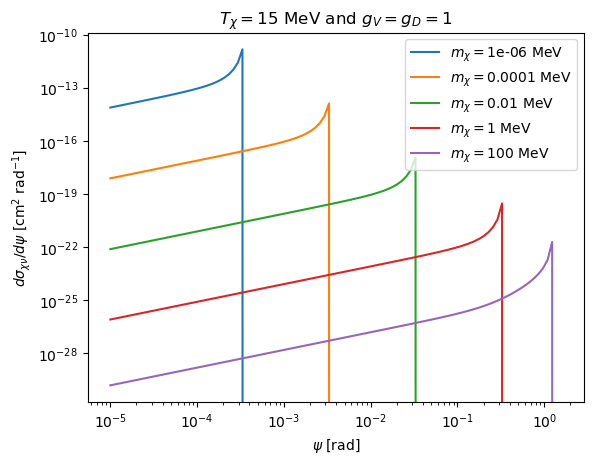

In [6]:
for i in range(len(mx_ls)):
    plt.plot(psi_ls,DMnu_crox_mx[i],label = r'$m_\chi=$' + str(mx_ls[i]) + ' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\psi$ [rad]')
plt.ylabel(r'$d\sigma_{\chi\nu}/d\psi$ [cm$^2$ rad$^{-1}$]')
plt.legend()
plt.title(r'$T_\chi = 15$ MeV and $g_V=g_D=1$')

In [7]:
# Calculate DM-e cross section
mx_ls = np.logspace(-6,1,100)
Tx_ls = [5,30,75,100]
DMe_crox_Tx = []
for Tx in Tx_ls:
    DMe_crox_mx = []
    for mx in mx_ls:
        mV = mx/3
        diff_crox = totalCrossSectionDMe(Tx,mx,mV,1,1)
        DMe_crox_mx.append(diff_crox)
    DMe_crox_Tx.append(DMe_crox_mx)

Text(0.5, 1.0, '$g_D=\\epsilon=1$')

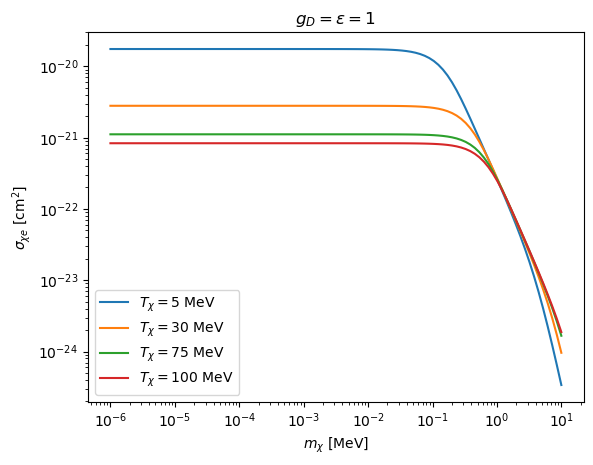

In [8]:
for i in range(len(Tx_ls)):
    plt.plot(mx_ls,DMe_crox_Tx[i],label = r'$T_\chi=$' + str(Tx_ls[i]) + ' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$\sigma_{\chi e}$ [cm$^2$]')
plt.legend()
plt.title(r'$g_D=\epsilon=1$')

3. `diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta,phi,beta,Re=8.5,r_cut=1e-5,gV=1,gD=1,tau=10)`: The differential BDM flux at Earth and the unit is [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]. The inputs are
    - `t`: The time in second
    - `Rstar`: The distance from SN to Earth, in kpc
    - `theta`: The open-angle along the line-of-sight of SN-Earth direction, in rad
    - `phi`: The azimuthal angle along the line-of-sight of SN-Earth direction, in rad
    - `beta`: The off-center angle, in rad. When beta = 0, it implies SN is at any position on the GC-Earth direction
    - `Re`: The distance between GC and Earth, in kpc, default 8.5
    - `r_cut`: Below which distance we should ignore the DM number density, in kpc, default 1e-5
    - `tau`: The duration of SN explosion, in second, default 10
<p>This function simply implies that
    $$
    \texttt{diffFluxAtEarth} = \frac{d\Phi_\chi(t)}{dtdT_\chi d\theta}.
    $$
    To get the flux at a specific time $t_s$, we do the following integration
    $$
    \frac{d\Phi_\chi (t_s)}{dt} = \int_0^{\theta_M} d\theta \int_{5\,{\rm MeV}}^{100\,{\rm MeV}} dT_\chi \frac{d\Phi_\chi(t_s)}{dtdT_\chi d\theta}
    $$
    where $\theta_M$ is the maximum open-angle that results in non-zero $d\Phi_\chi(t)/dtdT_\chi d\theta$. In principle one can set $\theta_M = \pi/2$. However, if $\theta_M$ can be determined in advance, it greatly reduces the difficulty of evaluating such integral. If $\theta_M$ is very small, eg. $10^{-5}$ and we take the upper bound as $\pi/2$, vegas might output 0 due to the Markov Chain is unable to reach the region of non-zero result.

4. `diffEventRateAtDetector(t,Tx,mx,mV,Rstar,theta,phi,beta,Re=8.5,r_cut=1e-5,gV=1,gD=1,eps=1,tau=10)`: The differential BDM event rate in the detector. The unit is [MeV$^{-1}$ s$^{-1}$ sr$^{-1}$ #$_e^{-1}$] and #$_e^{-1}$ means per electron. To get the correct differential event rate of a detector, one should multiply the associate total electron number $N_e$ of that detector. The inputs are
    - `eps`: DM-$e$ coupling constant, dimensionless, default 1
5. `thetaBound(t,Tx,mx,Rstar)`: Get the range of open angle theta for a given set of parameters.

6. `get_tvan_thetaM(Tx,mx,Rstar)`: Get the maximu open-angle $\theta_M$ that is required in the integration of differential BDM flux at Earth. This function outputs ($t_{\rm van}$,$\theta_M$). $t_{\rm van}$ indicates the vanishing time of the BDM flux in seconds and $\theta_M$ is the upper bound for the integration in rad. Note that $\theta_M$ corresponds to $t=0$.
    
#### Legacy function

7. `diffFluxAtEarthLegacy(t,Tx,mx,Rstar,theta,phi,beta,sigxv=1e-45,Re=8.5,r_cut=1e-5,tau=10)`: Legacy function that is exactly the same as `diffFluxAtEarth` but in terms of model-agnostic perspective. Thus the cross section $\sigma_{\chi\nu}$ is manual input and independent of coupling constants $g_V,g_D$ and mediator mass $m_V$.

In [18]:
# BDM kinematics
Tx = 10
mx1 = 1e-2
mx2 = 1e-1
mx3 = 1
# Rstar
Rstar = 8.5
# Off-center angle
beta = 0.0
# Get the vanishing time and maximum theta_M
tvan1,thetaM1 = get_tvan_thetaM(Tx,mx1,Rstar)
tvan2,thetaM2 = get_tvan_thetaM(Tx,mx2,Rstar)
tvan3,thetaM3 = get_tvan_thetaM(Tx,mx3,Rstar)
time_ls1 = np.logspace(np.log10(8),np.log10(tvan1),200)
time_ls2 = np.logspace(np.log10(8),np.log10(tvan2),200)
time_ls3 = np.logspace(np.log10(8),np.log10(tvan3),200)
gV=1e-6
gD=1e-6
#legacy = True
# setup function for ipyparallel
# the function is completely independent of this notebook
# everything required should be imported again within function body
def fluxToF(t,Tx,mx,mV,thetaM,Rstar,beta,gV,gD,legacy=False):
    # import necessary package
    import vegas
    import numpy as np
    integ = vegas.Integrator([[0, thetaM],[0,2*np.pi]])
    if beta == 0.0:
        if legacy is False:
            neval = 25000
        else:
            neval = 5000
    else:
        neval = 5000
    if legacy is False:
        from supernovaNuBoostedDM import diffFluxAtEarth
        # body
        try:
            result = integ(lambda x: diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta=x[0],phi=x[1],beta=beta,gV=gV,gD=gD),nitn=10,neval=neval).mean
        except:
            result = 0
    else:
        from bdmLegacy import diffFluxAtEarthLegacy
        # body
        try:
            result = integ(lambda x: diffFluxAtEarthLegacy(t,Tx,mx,Rstar,theta=x[0],phi=x[1],beta=beta,sigxv=1e-45),nitn=10,neval=neval).mean
        except:
            result = 0
    return result


# Setup ipyparallel
cpus = 6
with ipp.Cluster(n = cpus) as rc:
    # get a view on the cluster
    view = rc.load_balanced_view()
    # submit the tasks
    # legacy false
    asyncresult1 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx1,mV=mx1/3,thetaM=thetaM1,Rstar=Rstar,beta=beta,gV=gV,gD=gD,legacy=False), time_ls1.tolist())
    asyncresult2 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx2,mV=mx2/3,thetaM=thetaM2,Rstar=Rstar,beta=beta,gV=gV,gD=gD,legacy=False), time_ls2.tolist())
    asyncresult3 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx3,mV=mx3/3,thetaM=thetaM3,Rstar=Rstar,beta=beta,gV=gV,gD=gD,legacy=False), time_ls3.tolist())
    # legacy true
    asyncresult4 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx1,mV=mx1/3,thetaM=thetaM1,Rstar=Rstar,beta=beta,gV=gV,gD=gD,legacy=True), time_ls1.tolist())
    asyncresult5 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx2,mV=mx2/3,thetaM=thetaM2,Rstar=Rstar,beta=beta,gV=gV,gD=gD,legacy=True), time_ls2.tolist())
    asyncresult6 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx3,mV=mx3/3,thetaM=thetaM3,Rstar=Rstar,beta=beta,gV=gV,gD=gD,legacy=True), time_ls3.tolist())
    
    # wait interactively for results
    asyncresult1.wait_interactive()
    asyncresult2.wait_interactive()
    asyncresult3.wait_interactive()
    asyncresult4.wait_interactive()
    asyncresult5.wait_interactive()
    asyncresult6.wait_interactive()
    
    # retrieve actual results
    # legacy false result
    bdmflux1 = asyncresult1.get()
    bdmflux2 = asyncresult2.get()
    bdmflux3 = asyncresult3.get()
    # legacy true result
    bdmflux4 = asyncresult4.get()
    bdmflux5 = asyncresult5.get()
    bdmflux6 = asyncresult6.get()


Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

functools.partial(<function fluxToF at 0x7f7990f40670>, Tx=10, mx=0.01, mV=0.0033333333333333335, thetaM=0.044…

functools.partial(<function fluxToF at 0x7f7990f40670>, Tx=10, mx=0.1, mV=0.03333333333333333, thetaM=0.140489…

functools.partial(<function fluxToF at 0x7f7990f40670>, Tx=10, mx=1, mV=0.3333333333333333, thetaM=0.420534335…

functools.partial(<function fluxToF at 0x7f7990f40670>, Tx=10, mx=0.01, mV=0.0033333333333333335, thetaM=0.044…

functools.partial(<function fluxToF at 0x7f7990f40670>, Tx=10, mx=0.1, mV=0.03333333333333333, thetaM=0.140489…

functools.partial(<function fluxToF at 0x7f7990f40670>, Tx=10, mx=1, mV=0.3333333333333333, thetaM=0.420534335…

Stopping engine(s): 1692712521
engine set stopped 1692712521: {'engines': {'0': {'exit_code': 0, 'pid': 56079, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 56080, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 56081, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 56082, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 56083, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 56084, 'identifier': '5'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 56067, 'identifier': 'ipcontroller-1692712520-3xef-54824'}


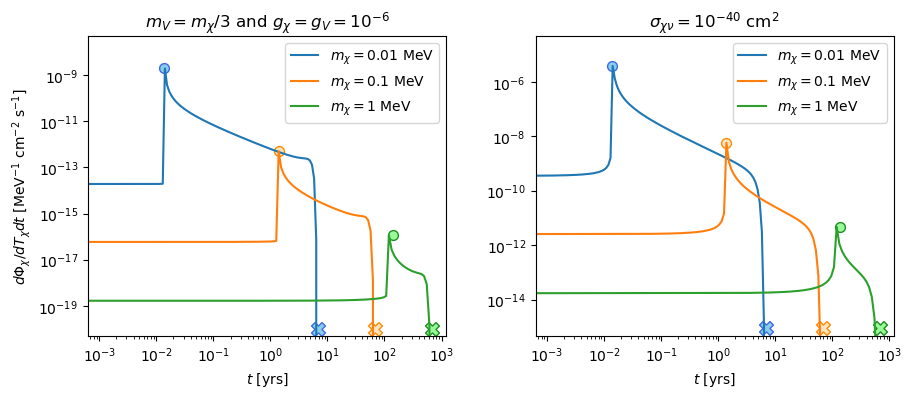

In [127]:
fig = plt.figure(figsize=(8*1.3,3*1.3))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.25)
#fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}~{\rm and}~R_s=8.5\,{\rm kpc}$')
(ax1, ax2) = gs.subplots(sharex='col')

ax1.set_title(r'$m_V=m_\chi/3~{\rm and}~g_\chi=g_V=10^{-6}$')
ax1.plot(time_ls1/yr2s,bdmflux1,color='C0',label=r'$m_\chi=0.01$ MeV')
ax1.plot(time_ls2/yr2s,bdmflux2,color='C1',label=r'$m_\chi=0.1$ MeV')
ax1.plot(time_ls3/yr2s,bdmflux3,color='C2',label=r'$m_\chi=1$ MeV')
# t_van markers
ax1.scatter(tvan_approx(10,mx1,Rstar)/yr2s,1e-20,marker='X',s=100,color='skyblue',ec='royalblue', lw=1)
ax1.scatter(tvan_approx(10,mx2,Rstar)/yr2s,1e-20,marker='X',s=100,color='bisque',ec='darkorange', lw=1)
ax1.scatter(tvan_approx(10,mx3,Rstar)/yr2s,1e-20,marker='X',s=100,color='palegreen',ec='forestgreen', lw=1)
# t_p markers
ax1.scatter(tp_approx(10,mx1,Rstar)/yr2s,np.max(bdmflux1),marker='o',s=50,color='skyblue',ec='royalblue', lw=1)
ax1.scatter(tp_approx(10,mx2,Rstar)/yr2s,np.max(bdmflux2),marker='o',s=50,color='bisque',ec='darkorange', lw=1)
ax1.scatter(tp_approx(10,mx3,Rstar)/yr2s,np.max(bdmflux3),marker='o',s=50,color='palegreen',ec='forestgreen', lw=1)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(6.3e-4,1200)
ax1.set_ylim(5e-21,5e-8)
ax1.set_ylabel(r'$d\Phi_\chi/dT_\chi dt$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
ax1.set_xlabel(r'$t$ [yrs]')
ax1.legend()
#ax1.text(3, 2.5e-15, r'$(R_s,\beta)=(8.5\,{\rm kpc},0)$')

ax2.set_title(r'$\sigma_{\chi\nu}=10^{-40}~{\rm cm^2}$')
ax2.plot(time_ls1/yr2s,np.asarray(bdmflux4)*1e5,color='C0',label=r'$m_\chi=0.01$ MeV')
ax2.plot(time_ls2/yr2s,np.asarray(bdmflux5)*1e5,color='C1',label=r'$m_\chi=0.1$ MeV')
ax2.plot(time_ls3/yr2s,np.asarray(bdmflux6)*1e5,color='C2',label=r'$m_\chi=1$ MeV')
# t_van markers
ax2.scatter(tvan_approx(10,mx1,Rstar)/yr2s,9e-16,marker='X',s=100,color='skyblue',ec='royalblue', lw=1)
ax2.scatter(tvan_approx(10,mx2,Rstar)/yr2s,9e-16,marker='X',s=100,color='bisque',ec='darkorange', lw=1)
ax2.scatter(tvan_approx(10,mx3,Rstar)/yr2s,9e-16,marker='X',s=100,color='palegreen',ec='forestgreen', lw=1)
# t_p markers
ax2.scatter(tp_approx(10,mx1,Rstar)/yr2s,np.max(bdmflux4)*1e5,marker='o',s=50,color='skyblue',ec='royalblue', lw=1)
ax2.scatter(tp_approx(10,mx2,Rstar)/yr2s,np.max(bdmflux5)*1e5,marker='o',s=50,color='bisque',ec='darkorange', lw=1)
ax2.scatter(tp_approx(10,mx3,Rstar)/yr2s,np.max(bdmflux6)*1e5,marker='o',s=50,color='palegreen',ec='forestgreen', lw=1)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(6.3e-4,1200)
ax2.set_ylim(4.5e-16,5e-5)
#ax2.set_ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV$^{-1}$ cm$^{-2}$]')
ax2.set_xlabel(r'$t$ [yrs]')
#ax2.text(3, 1.2e-8, r'$(R_s,\beta)=(8.5\,{\rm kpc},0)$')
ax2.legend()


#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(5.2e-3,210)
#plt.ylim(3.2e-13,1.3e-8)
plt.savefig('../plots/flux_v_mx.pdf',bbox_inches='tight')

In [138]:
tvan_approx(10,mx1,Rstar)/yr2s

6.935570165540036

In [88]:
# BDM kinematics
Tx = 10
mx = 0.1
mV = mx/3
# Rstar
Rstar1 = 8.5
Rstar2 = 8.7
Rstar3 = 8.9
Rstar4 = 9.1
Rstar5 = 10
Rstar6 = 11
Rstar7 = 13
Rstar8 = 15
# Off-center angle
beta1 = 0.04*np.pi
beta2 = np.pi/10
beta3 = np.pi/4
beta4 = np.pi
# Get the vanishing time and maximum theta_M
tvan1,thetaM1 = get_tvan_thetaM(Tx,mx,Rstar1)
tvan2,thetaM2 = get_tvan_thetaM(Tx,mx,Rstar2)
tvan3,thetaM3 = get_tvan_thetaM(Tx,mx,Rstar3)
tvan4,thetaM4 = get_tvan_thetaM(Tx,mx,Rstar4)
tvan5,thetaM5 = get_tvan_thetaM(Tx,mx,Rstar5)
tvan6,thetaM6 = get_tvan_thetaM(Tx,mx,Rstar6)
tvan7,thetaM7 = get_tvan_thetaM(Tx,mx,Rstar7)
tvan8,thetaM8 = get_tvan_thetaM(Tx,mx,Rstar8)

time_ls1 = np.logspace(3,np.log10(tvan1),200)
time_ls2 = np.logspace(3,np.log10(tvan2),200)
time_ls3 = np.logspace(3,np.log10(tvan3),200)
time_ls4 = np.logspace(3,np.log10(tvan4),200)
time_ls5 = np.logspace(3,np.log10(tvan5),200)
time_ls6 = np.logspace(3,np.log10(tvan6),200)
time_ls7 = np.logspace(3,np.log10(tvan7),200)
time_ls8 = np.logspace(3,np.log10(tvan8),200)


gV=1e-6
gD=1e-6
legacy = True
# setup function for ipyparallel
# the function is completely independent of this notebook
# everything required should be imported again within function body
def fluxToF(t,Tx,mx,mV,thetaM,Rstar,beta,gV,gD,legacy=False):
    # import necessary package
    import vegas
    import numpy as np
    integ = vegas.Integrator([[0, thetaM],[0,2*np.pi]])
    if beta == 0.0:
        neval = 20000
    else:
        neval = 2000
    if legacy is False:
        from supernovaNuBoostedDM import diffFluxAtEarth
        # body
        try:
            result = integ(lambda x: diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta=x[0],phi=x[1],beta=beta,gV=gV,gD=gD),nitn=10,neval=neval).mean
        except:
            result = 0
    else:
        from bdmLegacy import diffFluxAtEarthLegacy
        # body
        try:
            result = integ(lambda x: diffFluxAtEarthLegacy(t,Tx,mx,Rstar,theta=x[0],phi=x[1],beta=beta,sigxv=1e-45),nitn=10,neval=neval).mean
        except:
            result = 0
    return result


# Setup ipyparallel
cpus = 4
with ipp.Cluster(n = cpus) as rc:
    # get a view on the cluster
    view = rc.load_balanced_view()
    # submit the tasks
    asyncresult1 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV/3,thetaM=thetaM1,Rstar=Rstar1,beta=beta1,gV=gV,gD=gD,legacy=legacy), time_ls1.tolist())
    asyncresult2 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV/3,thetaM=thetaM2,Rstar=Rstar2,beta=beta1,gV=gV,gD=gD,legacy=legacy), time_ls2.tolist())
    asyncresult3 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV/3,thetaM=thetaM3,Rstar=Rstar3,beta=beta1,gV=gV,gD=gD,legacy=legacy), time_ls3.tolist())
    asyncresult4 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV/3,thetaM=thetaM4,Rstar=Rstar4,beta=beta1,gV=gV,gD=gD,legacy=legacy), time_ls4.tolist())
    asyncresult5 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV/3,thetaM=thetaM5,Rstar=Rstar5,beta=beta1,gV=gV,gD=gD,legacy=legacy), time_ls5.tolist())
    asyncresult6 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV/3,thetaM=thetaM6,Rstar=Rstar6,beta=beta1,gV=gV,gD=gD,legacy=legacy), time_ls6.tolist())
    asyncresult7 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV/3,thetaM=thetaM7,Rstar=Rstar7,beta=beta1,gV=gV,gD=gD,legacy=legacy), time_ls7.tolist())
    asyncresult8 = view.map_async(partial(fluxToF,Tx=Tx,mx=mx,mV=mV/3,thetaM=thetaM8,Rstar=Rstar8,beta=beta1,gV=gV,gD=gD,legacy=legacy), time_ls8.tolist())

    # wait interactively for results
    asyncresult1.wait_interactive()
    asyncresult2.wait_interactive()
    asyncresult3.wait_interactive()
    asyncresult4.wait_interactive()
    asyncresult5.wait_interactive()
    asyncresult6.wait_interactive()
    asyncresult7.wait_interactive()
    asyncresult8.wait_interactive()

    # retrieve actual results
    if legacy is False:
        bdmflux1 = asyncresult1.get()
        bdmflux2 = asyncresult2.get()
        bdmflux3 = asyncresult3.get()
        bdmflux4 = asyncresult4.get()
        bdmflux5 = asyncresult5.get()
        bdmflux6 = asyncresult6.get()
        bdmflux7 = asyncresult7.get()
        bdmflux8 = asyncresult8.get()
    else:
        bdmflux1_legacy = asyncresult1.get()
        bdmflux2_legacy = asyncresult2.get()
        bdmflux3_legacy = asyncresult3.get()
        bdmflux4_legacy = asyncresult4.get()
        bdmflux5_legacy = asyncresult5.get()
        bdmflux6_legacy = asyncresult6.get()
        bdmflux7_legacy = asyncresult7.get()
        bdmflux8_legacy = asyncresult8.get()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

functools.partial(<function fluxToF at 0x7fd994735a60>, Tx=10, mx=0.1, mV=0.011111111111111112, thetaM=0.14048…

functools.partial(<function fluxToF at 0x7fd994735a60>, Tx=10, mx=0.1, mV=0.011111111111111112, thetaM=0.14048…

functools.partial(<function fluxToF at 0x7fd994735a60>, Tx=10, mx=0.1, mV=0.011111111111111112, thetaM=0.14048…

functools.partial(<function fluxToF at 0x7fd994735a60>, Tx=10, mx=0.1, mV=0.011111111111111112, thetaM=0.14048…

functools.partial(<function fluxToF at 0x7fd994735a60>, Tx=10, mx=0.1, mV=0.011111111111111112, thetaM=0.14048…

functools.partial(<function fluxToF at 0x7fd994735a60>, Tx=10, mx=0.1, mV=0.011111111111111112, thetaM=0.14048…

functools.partial(<function fluxToF at 0x7fd994735a60>, Tx=10, mx=0.1, mV=0.011111111111111112, thetaM=0.14048…

functools.partial(<function fluxToF at 0x7fd994735a60>, Tx=10, mx=0.1, mV=0.011111111111111112, thetaM=0.14048…

Stopping engine(s): 1693872290
engine set stopped 1693872290: {'engines': {'0': {'exit_code': 0, 'pid': 60746, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 60747, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 60748, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 60749, 'identifier': '3'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 60734, 'identifier': 'ipcontroller-1693872289-o6ox-56422'}


Text(0, 0.5, '$d\\Phi_\\chi/dT_\\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')

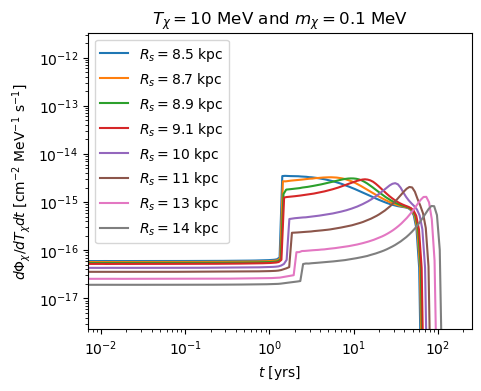

In [51]:
plt.figure(figsize=(4.5*1.1,3.5*1.1))
plt.plot(time_ls1/yr2s,np.asarray(bdmflux1),color='C0',label=r'$R_s=8.5$ kpc')
#plt.scatter(tp_approx(10,mx,Rstar1)/yr2s,np.max(bdmflux1_legacy)*1e5,marker='o',color='C0')
plt.plot(time_ls2/yr2s,np.asarray(bdmflux2),color='C1',label=r'$R_s=8.7$ kpc')
#plt.scatter(tp_approx(10,mx,Rstar2)/yr2s,np.max(bdmflux2_legacy)*1e5,marker='o',color='C1')
plt.plot(time_ls3/yr2s,np.asarray(bdmflux3),color='C2',label=r'$R_s=8.9$ kpc')
#plt.scatter(tp_approx(10,mx,Rstar3)/yr2s,np.max(bdmflux3_legacy)*1e5,marker='o',color='C2')
plt.plot(time_ls4/yr2s,np.asarray(bdmflux4),color='C3',label=r'$R_s=9.1$ kpc')
plt.plot(time_ls5/yr2s,np.asarray(bdmflux5),color='C4',label=r'$R_s=10$ kpc')
plt.plot(time_ls6/yr2s,np.asarray(bdmflux6),color='C5',label=r'$R_s=11$ kpc')
plt.plot(time_ls7/yr2s,np.asarray(bdmflux7),color='C6',label=r'$R_s=13$ kpc')
plt.plot(time_ls8/yr2s,np.asarray(bdmflux8),color='C7',label=r'$R_s=14$ kpc')



plt.xlim(7e-3,250)
plt.xscale('log')
plt.ylim(2.3e-18,3.3e-12)
plt.yscale('log')
plt.legend(loc='upper left')
plt.xlabel('$t$ [yrs]')
plt.title(r'$T_\chi=10$ MeV and $m_\chi=0.1$ MeV')
plt.ylabel('$d\Phi_\chi/dT_\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')
#plt.savefig('../plots/various_Rs_2.pdf',bbox_inches='tight')

In [58]:
def pathBeta(beta):
    return '../data/various_Rs_Tx10_mx0.1_beta' + str(beta) + 'pi'

betaList = [0,0.02,0.05,0.1]
rList = [8.5,11,15]

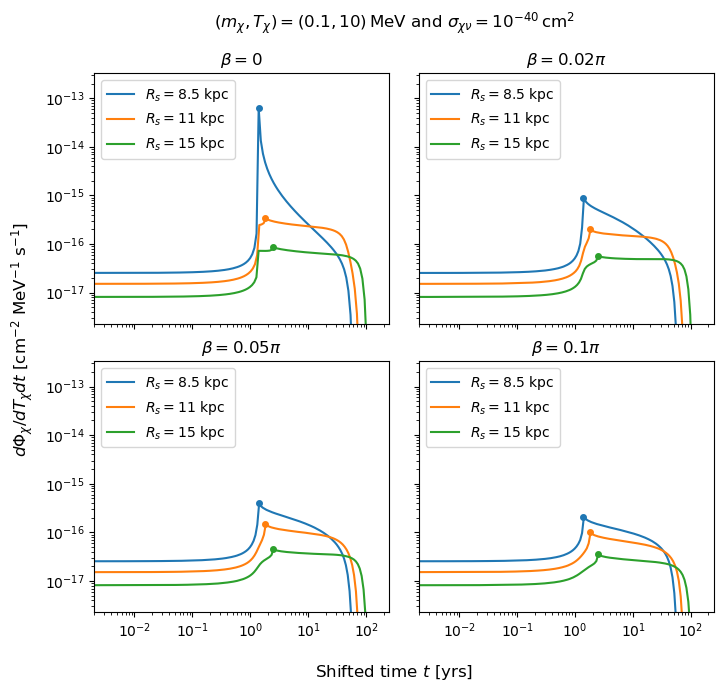

In [69]:
fig = plt.figure(figsize=(8,7))
gs = fig.add_gridspec(2, 2, hspace=1.5e-1, wspace=1e-1)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}$ and $\sigma_{\chi \nu}=10^{-40}\,{\rm cm}^2$',y=0.97)
for i in range(1,5):
    for j in range(3):
        Rs = rList[j]
        flux = np.loadtxt(pathBeta(betaList[i-1]) + '/Rs_' + str(Rs) + '.txt')
        eval(f'ax{i}.plot(flux.T[0],flux.T[1],color=\'C{j}\',label=r\'$R_s=$\'+ str(Rs)+\' kpc\')')
        eval(f'ax{i}.scatter(tp_approx(10,0.1,Rs)/yr2s,np.max(flux.T[1]),marker=\'.\',lw=2,color=\'C{j}\')')
    if i == 1:
        eval(f'ax{i}.set_title(r\'$\u03B2=$\' + str({betaList[i-1]}) )')
    else:
        eval(f'ax{i}.set_title(r\'$\u03B2=$\' + str({betaList[i-1]}) + \'$\u03C0$\')')
    eval(f'ax{i}.legend(loc=\'upper left\')')
    eval(f'ax{i}.set_xlim(2e-3,250)')
    eval(f'ax{i}.set_ylim(2.3e-18,3.3e-13)')
    eval(f'ax{i}.set_xscale(\'log\')')
    eval(f'ax{i}.set_yscale(\'log\')')
    

#for i in range(3):
#    ax2.plot(flux_Rstar_beta2[i,:,0]/yr2s,flux_Rstar_beta2[i,:,1],label=r'$R_s = $'+str(Rstar[i])+' kpc')
#ax2.set_xlim(3e-2,170)
#ax2.set_title(r'$\beta=$' + f'$\pi/4$')
#ax2.legend()
#for i in range(3):
#    ax3.plot(flux_Rstar_beta3[i,:,0]/yr2s,flux_Rstar_beta3[i,:,1],label=r'$R_s = $'+str(Rstar[i])+' kpc')
#ax3.set_ylim(3e-18,4.3e-13)
#ax3.set_title(r'$\beta=$' + f'$\pi/2$')
#ax3.legend()
#for i in range(3):
#    ax4.plot(flux_Rstar_beta4[i,:,0]/yr2s,flux_Rstar_beta4[i,:,1],label=r'$R_s = $'+str(Rstar[i])+' kpc')
#ax4.set_title(r'$\beta=$' + f'$\pi$')
#ax4.legend()
    # Dealing with axes
#for i in range(1,5):
    # set both x and y axes into log-scale
    
# Set commom labels
#handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, 0.93), borderaxespad=0)
fig.supxlabel(r'Shifted time $t$ [yrs]')
fig.supylabel(r'$d\Phi_\chi/dT_\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')
fig.savefig('../plots/flux_Rs_v_beta.pdf',bbox_inches='tight')

In [ ]:
for beta in betaList:
    for Rs in rList:
        np.loadtxt(path + '/Rs_' + str(Rs) + '.txt')

In [90]:
for i in range(4):
    np.savetxt(path+'/Rs_'+str(eval('Rstar'+str(i)))+'.txt',np.vstack((eval('time_ls'+str(i))/yr2s,eval('bdmflux'+str(i)+'_legacy'))).T,fmt='%.5e')

In [156]:
rs85 = np.loadtxt(path + '/Rs_8.5.txt')
rs87 = np.loadtxt(path + '/Rs_8.7.txt')
rs89 = np.loadtxt(path + '/Rs_8.9.txt')
rs91 = np.loadtxt(path + '/Rs_9.1.txt')
rs10 = np.loadtxt(path + '/Rs_10.txt')
rs11 = np.loadtxt(path + '/Rs_11.txt')
rs13 = np.loadtxt(path + '/Rs_13.txt')
rs15 = np.loadtxt(path + '/Rs_15.txt')

rs85constNx = np.loadtxt(path + '/Rs_8.5_constNx.txt')
rs87constNx = np.loadtxt(path + '/Rs_8.7_constNx.txt')
rs89constNx = np.loadtxt(path + '/Rs_8.9_constNx.txt')
rs91constNx = np.loadtxt(path + '/Rs_9.1_constNx.txt')
rs10constNx = np.loadtxt(path + '/Rs_10_constNx.txt')
rs11constNx = np.loadtxt(path + '/Rs_11_constNx.txt')
rs13constNx = np.loadtxt(path + '/Rs_13_constNx.txt')
rs15constNx = np.loadtxt(path + '/Rs_15_constNx.txt')

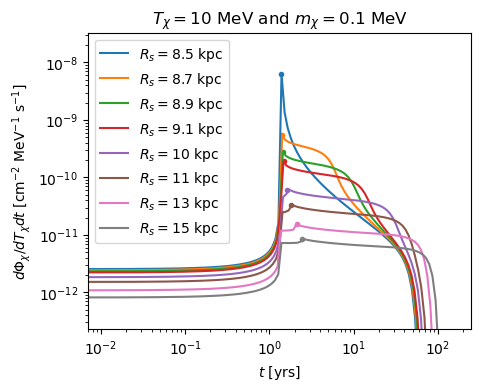

In [159]:
plt.figure(figsize=(4.5*1.1,3.5*1.1))
plt.plot(rs85.T[0],rs85.T[1]*1e5,color='C0',label=r'$R_s=8.5$ kpc')
plt.plot(rs87.T[0],rs87.T[1]*1e5,color='C1',label=r'$R_s=8.7$ kpc')
plt.plot(rs89.T[0],rs89.T[1]*1e5,color='C2',label=r'$R_s=8.9$ kpc')
plt.plot(rs91.T[0],rs91.T[1]*1e5,color='C3',label=r'$R_s=9.1$ kpc')
plt.plot(rs10.T[0],rs10.T[1]*1e5,color='C4',label=r'$R_s=10$ kpc')
plt.plot(rs11.T[0],rs11.T[1]*1e5,color='C5',label=r'$R_s=11$ kpc')
plt.plot(rs13.T[0],rs13.T[1]*1e5,color='C6',label=r'$R_s=13$ kpc')
plt.plot(rs15.T[0],rs15.T[1]*1e5,color='C7',label=r'$R_s=15$ kpc')

plt.scatter(tp_approx(10,mx,8.5)/yr2s,np.max(rs85.T[1])*1e5,marker='.',color='C0')
plt.scatter(tp_approx(10,mx,8.7)/yr2s,np.max(rs87.T[1])*1e5,marker='.',color='C1')
plt.scatter(tp_approx(10,mx,8.9)/yr2s,np.max(rs89.T[1])*1e5,marker='.',color='C2')
plt.scatter(tp_approx(10,mx,9.1)/yr2s,np.max(rs91.T[1])*1e5,marker='.',color='C3')
plt.scatter(tp_approx(10,mx,10)/yr2s,np.max(rs10.T[1])*1e5,marker='.',color='C4')
plt.scatter(tp_approx(10,mx,11)/yr2s,np.max(rs11.T[1])*1e5,marker='.',color='C5')
plt.scatter(tp_approx(10,mx,13)/yr2s,np.max(rs13.T[1])*1e5,marker='.',color='C6')
plt.scatter(tp_approx(10,mx,15)/yr2s,np.max(rs15.T[1])*1e5,marker='.',color='C7')

plt.xlim(7e-3,250)
plt.xscale('log')
plt.ylim(2.3e-13,3.3e-8)
plt.yscale('log')
plt.legend()
plt.xlabel('$t$ [yrs]')
plt.title(r'$T_\chi=10$ MeV and $m_\chi=0.1$ MeV')
plt.ylabel('$d\Phi_\chi/dT_\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')
plt.savefig('../plots/various_Rs.pdf',bbox_inches='tight')

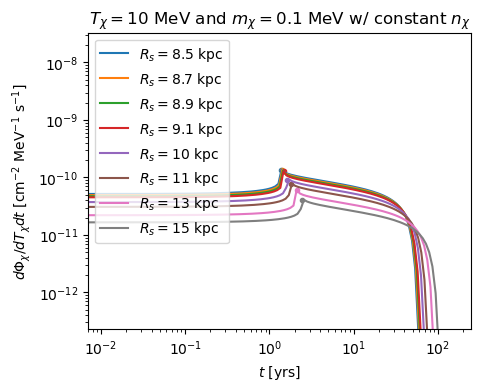

In [160]:
plt.figure(figsize=(4.5*1.1,3.5*1.1))
plt.plot(rs85constNx.T[0],rs85constNx.T[1]*1e5,color='C0',label=r'$R_s=8.5$ kpc')
plt.plot(rs87constNx.T[0],rs87constNx.T[1]*1e5,color='C1',label=r'$R_s=8.7$ kpc')
plt.plot(rs89constNx.T[0],rs89constNx.T[1]*1e5,color='C2',label=r'$R_s=8.9$ kpc')
plt.plot(rs91constNx.T[0],rs91constNx.T[1]*1e5,color='C3',label=r'$R_s=9.1$ kpc')
plt.plot(rs10constNx.T[0],rs10constNx.T[1]*1e5,color='C4',label=r'$R_s=10$ kpc')
plt.plot(rs11constNx.T[0],rs11constNx.T[1]*1e5,color='C5',label=r'$R_s=11$ kpc')
plt.plot(rs13constNx.T[0],rs13constNx.T[1]*1e5,color='C6',label=r'$R_s=13$ kpc')
plt.plot(rs15constNx.T[0],rs15constNx.T[1]*1e5,color='C7',label=r'$R_s=15$ kpc')

plt.scatter(tp_approx(10,mx,8.5)/yr2s,np.max(rs85constNx.T[1])*1e5,marker='.',color='C0')
plt.scatter(tp_approx(10,mx,8.7)/yr2s,np.max(rs87constNx.T[1])*1e5,marker='.',color='C1')
plt.scatter(tp_approx(10,mx,8.9)/yr2s,np.max(rs89constNx.T[1])*1e5,marker='.',color='C2')
plt.scatter(tp_approx(10,mx,9.1)/yr2s,np.max(rs91constNx.T[1])*1e5,marker='.',color='C3')
plt.scatter(tp_approx(10,mx,10)/yr2s,np.max(rs10constNx.T[1])*1e5,marker='.',color='C4')
plt.scatter(tp_approx(10,mx,11)/yr2s,np.max(rs11constNx.T[1])*1e5,marker='.',color='C5')
plt.scatter(tp_approx(10,mx,13)/yr2s,np.max(rs13constNx.T[1])*1e5,marker='.',color='C6')
plt.scatter(tp_approx(10,mx,15)/yr2s,np.max(rs15constNx.T[1])*1e5,marker='.',color='C7')
plt.xlim(7e-3,250)
plt.xscale('log')
plt.ylim(2.3e-13,3.3e-8)
plt.yscale('log')
plt.legend(loc='upper left')
plt.xlabel('$t$ [yrs]')
plt.title(r'$T_\chi=10$ MeV and $m_\chi=0.1$ MeV w/ constant $n_\chi$')
plt.ylabel('$d\Phi_\chi/dT_\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')
plt.savefig('../plots/various_Rs_constNx.pdf',bbox_inches='tight')

In [9]:
def find_nearest_arg(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [91]:
rs85_lmlt = np.loadtxt(path + '/Rs_8.5.txt')
rs87_lmlt = np.loadtxt(path + '/Rs_8.7.txt')
rs89_lmlt = np.loadtxt(path + '/Rs_8.9.txt')
rs91_lmlt = np.loadtxt(path + '/Rs_9.1.txt')
rs10_lmlt = np.loadtxt(path + '/Rs_10.txt')
rs11_lmlt = np.loadtxt(path + '/Rs_11.txt')
rs13_lmlt = np.loadtxt(path + '/Rs_13.txt')
rs15_lmlt = np.loadtxt(path + '/Rs_15.txt')

#rs85_lmlt_constNx = np.loadtxt(path + '/Rs_8.5_Lm-Lt_constNx.txt')
#rs87_lmlt_constNx = np.loadtxt(path + '/Rs_8.7_Lm-Lt_constNx.txt')
#rs89_lmlt_constNx = np.loadtxt(path + '/Rs_8.9_Lm-Lt_constNx.txt')
#rs91_lmlt_constNx = np.loadtxt(path + '/Rs_9.1_Lm-Lt_constNx.txt')
#rs10_lmlt_constNx = np.loadtxt(path + '/Rs_10_Lm-Lt_constNx.txt')
#rs11_lmlt_constNx = np.loadtxt(path + '/Rs_11_Lm-Lt_constNx.txt')
#rs13_lmlt_constNx = np.loadtxt(path + '/Rs_13_Lm-Lt_constNx.txt')
#rs15_lmlt_constNx = np.loadtxt(path + '/Rs_15_Lm-Lt_constNx.txt')

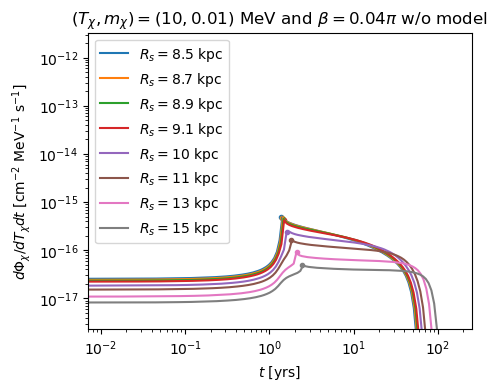

In [92]:
plt.figure(figsize=(4.5*1.1,3.5*1.1))
plt.plot(rs85_lmlt.T[0],rs85_lmlt.T[1],color='C0',label=r'$R_s=8.5$ kpc')
plt.plot(rs87_lmlt.T[0],rs87_lmlt.T[1],color='C1',label=r'$R_s=8.7$ kpc')
plt.plot(rs89_lmlt.T[0],rs89_lmlt.T[1],color='C2',label=r'$R_s=8.9$ kpc')
plt.plot(rs91_lmlt.T[0],rs91_lmlt.T[1],color='C3',label=r'$R_s=9.1$ kpc')
plt.plot(rs10_lmlt.T[0],rs10_lmlt.T[1],color='C4',label=r'$R_s=10$ kpc')
plt.plot(rs11_lmlt.T[0],rs11_lmlt.T[1],color='C5',label=r'$R_s=11$ kpc')
plt.plot(rs13_lmlt.T[0],rs13_lmlt.T[1],color='C6',label=r'$R_s=13$ kpc')
plt.plot(rs15_lmlt.T[0],rs15_lmlt.T[1],color='C7',label=r'$R_s=15$ kpc')

plt.scatter(tp_approx(10,mx,8.5)/yr2s,rs85_lmlt.T[1][find_nearest_arg(rs85_lmlt.T[0], tp_approx(10,mx,8.5)/yr2s)],marker='.',color='C0')
plt.scatter(tp_approx(10,mx,8.7)/yr2s,rs87_lmlt.T[1][find_nearest_arg(rs87_lmlt.T[0], tp_approx(10,mx,8.7)/yr2s)],marker='.',color='C1')
plt.scatter(tp_approx(10,mx,8.9)/yr2s,rs89_lmlt.T[1][find_nearest_arg(rs89_lmlt.T[0], tp_approx(10,mx,8.9)/yr2s)],marker='.',color='C2')
plt.scatter(tp_approx(10,mx,9.1)/yr2s,rs91_lmlt.T[1][find_nearest_arg(rs91_lmlt.T[0], tp_approx(10,mx,9.1)/yr2s)],marker='.',color='C3')
plt.scatter(tp_approx(10,mx,10)/yr2s,rs10_lmlt.T[1][find_nearest_arg(rs10_lmlt.T[0], tp_approx(10,mx,10)/yr2s)],marker='.',color='C4')
plt.scatter(tp_approx(10,mx,11)/yr2s,rs11_lmlt.T[1][find_nearest_arg(rs11_lmlt.T[0], tp_approx(10,mx,11)/yr2s)],marker='.',color='C5')
plt.scatter(tp_approx(10,mx,13)/yr2s,rs13_lmlt.T[1][find_nearest_arg(rs13_lmlt.T[0], tp_approx(10,mx,13)/yr2s)],marker='.',color='C6')
plt.scatter(tp_approx(10,mx,15)/yr2s,rs15_lmlt.T[1][find_nearest_arg(rs15_lmlt.T[0], tp_approx(10,mx,15)/yr2s)],marker='.',color='C7')


plt.xlim(7e-3,250)
plt.xscale('log')
plt.ylim(2.3e-18,3.3e-12)
plt.yscale('log')
plt.legend()
plt.xlabel('$t$ [yrs]')
plt.title(r'$(T_\chi,m_\chi)=(10,0.01)$ MeV and $\beta=0.04\pi$ w/o model')
plt.ylabel('$d\Phi_\chi/dT_\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')
plt.savefig('../plots/various_Rs_beta0.04pi_noModel.pdf',bbox_inches='tight')

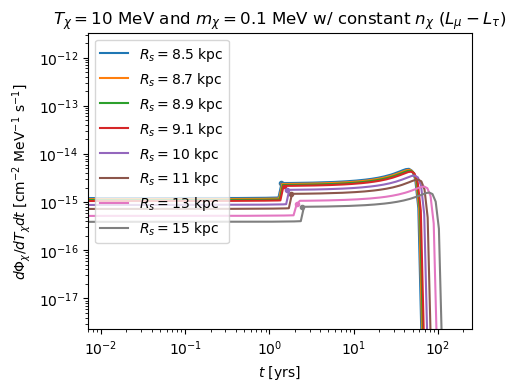

In [205]:
plt.figure(figsize=(4.5*1.1,3.5*1.1))
plt.plot(rs85_lmlt_constNx.T[0],rs85_lmlt_constNx.T[1],color='C0',label=r'$R_s=8.5$ kpc')
plt.plot(rs87_lmlt_constNx.T[0],rs87_lmlt_constNx.T[1],color='C1',label=r'$R_s=8.7$ kpc')
plt.plot(rs89_lmlt_constNx.T[0],rs89_lmlt_constNx.T[1],color='C2',label=r'$R_s=8.9$ kpc')
plt.plot(rs91_lmlt_constNx.T[0],rs91_lmlt_constNx.T[1],color='C3',label=r'$R_s=9.1$ kpc')
plt.plot(rs10_lmlt_constNx.T[0],rs10_lmlt_constNx.T[1],color='C4',label=r'$R_s=10$ kpc')
plt.plot(rs11_lmlt_constNx.T[0],rs11_lmlt_constNx.T[1],color='C5',label=r'$R_s=11$ kpc')
plt.plot(rs13_lmlt_constNx.T[0],rs13_lmlt_constNx.T[1],color='C6',label=r'$R_s=13$ kpc')
plt.plot(rs15_lmlt_constNx.T[0],rs15_lmlt_constNx.T[1],color='C7',label=r'$R_s=15$ kpc')

plt.scatter(tp_approx(10,mx,8.5)/yr2s,rs85_lmlt_constNx.T[1][find_nearest_arg(rs85_lmlt_constNx.T[0], tp_approx(10,mx,8.5)/yr2s)],marker='.',color='C0')
plt.scatter(tp_approx(10,mx,8.7)/yr2s,rs87_lmlt_constNx.T[1][find_nearest_arg(rs87_lmlt_constNx.T[0], tp_approx(10,mx,8.7)/yr2s)],marker='.',color='C1')
plt.scatter(tp_approx(10,mx,8.9)/yr2s,rs89_lmlt_constNx.T[1][find_nearest_arg(rs89_lmlt_constNx.T[0], tp_approx(10,mx,8.9)/yr2s)],marker='.',color='C2')
plt.scatter(tp_approx(10,mx,9.1)/yr2s,rs91_lmlt_constNx.T[1][find_nearest_arg(rs91_lmlt_constNx.T[0], tp_approx(10,mx,9.1)/yr2s)],marker='.',color='C3')
plt.scatter(tp_approx(10,mx,10)/yr2s,rs10_lmlt_constNx.T[1][find_nearest_arg(rs10_lmlt_constNx.T[0], tp_approx(10,mx,10)/yr2s)+1],marker='.',color='C4')
plt.scatter(tp_approx(10,mx,11)/yr2s,rs11_lmlt_constNx.T[1][find_nearest_arg(rs11_lmlt_constNx.T[0], tp_approx(10,mx,11)/yr2s)],marker='.',color='C5')
plt.scatter(tp_approx(10,mx,13)/yr2s,rs13_lmlt_constNx.T[1][find_nearest_arg(rs13_lmlt_constNx.T[0], tp_approx(10,mx,13)/yr2s)],marker='.',color='C6')
plt.scatter(tp_approx(10,mx,15)/yr2s,rs15_lmlt_constNx.T[1][find_nearest_arg(rs15_lmlt_constNx.T[0], tp_approx(10,mx,15)/yr2s)+1],marker='.',color='C7')


plt.xlim(7e-3,250)
plt.xscale('log')
plt.ylim(2.3e-18,3.3e-12)
plt.yscale('log')
plt.legend(loc='upper left')
plt.xlabel('$t$ [yrs]')
plt.title(r'$T_\chi=10$ MeV and $m_\chi=0.1$ MeV w/ constant $n_\chi$ ($L_\mu-L_\tau$)')
plt.ylabel('$d\Phi_\chi/dT_\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')
plt.savefig('../plots/various_Rs_Lm-Lt_constNx.pdf',bbox_inches='tight')

In [195]:
rs85_lmlt.T[1][find_nearest_arg(rs85_lmlt.T[0], tp_approx(10,mx,8.5)/yr2s)]

5.49202e-13

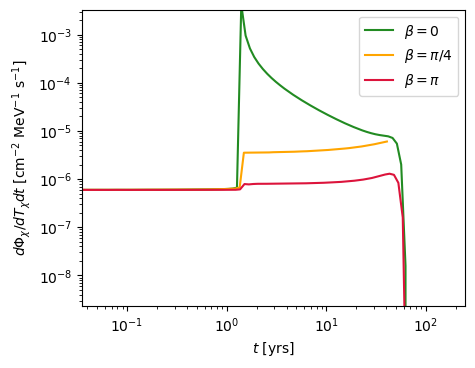

In [15]:
plt.figure(figsize=(4.5*1.1,3.5*1.1))
plt.plot(time_ls1/yr2s,np.asarray(bdmflux1)*1e10,color='forestgreen',label=r'$\beta=0$')
#plt.plot(time_ls2/yr2s,np.asarray(bdmflux2_legacy)*1e10,label=r'$\beta=\pi/10$')
plt.plot(time_ls3/yr2s,np.asarray(bdmflux3)*1e10,color='orange',label=r'$\beta=\pi/4$')
plt.plot(time_ls4/yr2s,np.asarray(bdmflux4)*1e10,color='crimson',label=r'$\beta=\pi$')
plt.xlim(3.5e-2,250)
plt.xscale('log')
plt.ylim(2.3e-9,3.3e-3)
plt.yscale('log')
plt.legend()
plt.xlabel('$t$ [yrs]')
#plt.title(r'$\beta=0$')
plt.ylabel('$d\Phi_\chi/dT_\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')
plt.savefig('../plots/test_Dcut.pdf',bbox_inches='tight')

In [2]:
from supernovaNuBoostedDM import dnv

In [17]:
dnv(1e-4,20)

8664636229.28184

In [86]:
# BDM kinematics
Tx_ls = np.linspace(5,100,200)
mx = 1
mV = mx/3
# Rstar
Rstar1 = 8.5
#Rstar2 = 9
#Rstar3 = 5
#Rstar4 = 12
# Off-center angle
beta1 = 0.01
#beta2 = np.pi/10
#beta3 = np.pi/4
#beta4 = np.pi
# Get the vanishing time and maximum theta_M
#tvan1,thetaM1 = get_tvan_thetaM(5,mx,Rstar1)
#thetaM1 = np.pi/2
#time = tvan1/1000
#tvan2,thetaM2 = get_tvan_thetaM(Tx,mx,Rstar2)
#tvan3,thetaM3 = get_tvan_thetaM(Tx,mx,Rstar3)
#tvan4,thetaM4 = get_tvan_thetaM(Tx,mx,Rstar4)
#time_ls1 = np.logspace(np.log10(5),np.log10(tvan1),200)
#time_ls2 = np.logspace(np.log10(5),np.log10(tvan2),200)
#time_ls3 = np.logspace(np.log10(5),np.log10(tvan3),200)
#time_ls4 = np.logspace(np.log10(5),np.log10(tvan4),200)
gV=1e-6
gD=1e-6
#legacy = True
# setup function for ipyparallel
# the function is completely independent of this notebook
# everything required should be imported again within function body
def fluxTx(Tx,mx,mV,Rstar,beta,gV,gD,tvan_cut=35*yr2s,legacy=False):
    # import necessary package
    import vegas
    import numpy as np
    from supernovaNuBoostedDM import get_tvan_thetaM,diffFluxAtEarth
    tvan,thetaM = get_tvan_thetaM(Tx,mx,Rstar)
    #if tvan_cut is not False:
    #    if tvan <= tvan_cut: pass
    #    else: tvan = tvan_cut
    tvan = tvan/5
    integ = vegas.Integrator([[10, tvan],[0, thetaM],[0,2*np.pi]])
    if beta == 0.0:
        neval = 10000
    else:
        neval = 10000
    if legacy is False:
        # body
        try:
            result = integ(lambda x: diffFluxAtEarth(x[0],Tx,mx,mV,Rstar,theta=x[1],phi=x[2],beta=beta,gV=gV,gD=gD),nitn=10,neval=neval).mean
        except:
            result = 0
    else:
        from bdmLegacy import diffFluxAtEarthLegacy
        # body
        try:
            result = integ(lambda x: diffFluxAtEarthLegacy(x[0],Tx,mx,Rstar,theta=x[1],phi=x[2],beta=beta,sigxv=1e-45),nitn=10,neval=neval).mean
        except:
            result = 0
    return result


# Setup ipyparallel
cpus = 6
with ipp.Cluster(n = cpus) as rc:
    # get a view on the cluster
    view = rc.load_balanced_view()
    # submit the tasks
    #asyncresult = view.map_async(partial(fluxTx,mx=mx,mV=mx/3,Rstar=Rstar1,beta=beta1,gV=gV,gD=gD,legacy=False), Tx_ls.tolist())
    #asyncresult_no_tvan_cut = view.map_async(partial(fluxTx,mx=mx,mV=mx/3,Rstar=Rstar1,beta=beta1,gV=gV,gD=gD,tvan_cut=False,legacy=False), Tx_ls.tolist())
    #asyncresult_legacy = view.map_async(partial(fluxTx,mx=mx,mV=mx/3,Rstar=Rstar1,beta=beta1,gV=gV,gD=gD,legacy=True), Tx_ls.tolist())
    #asyncresult_legacy_no_tvan_cut = view.map_async(partial(fluxTx,mx=mx,mV=mx/3,Rstar=Rstar1,beta=beta1,gV=gV,gD=gD,tvan_cut=False,legacy=True), Tx_ls.tolist())
    # wait interactively for results
    #asyncresult.wait_interactive()
    #asyncresult_no_tvan_cut.wait_interactive()
    #asyncresult_legacy.wait_interactive()
    #asyncresult_legacy_no_tvan_cut.wait_interactive()
    # retrieve actual results
    #bdmfluxEnergy = asyncresult.get()
    #bdmfluxEnergy_no_tvan_cut = asyncresult_no_tvan_cut.get()
    #bdmfluxEnergy_legacy = asyncresult_legacy.get()
    #bdmfluxEnergy_legacy_no_tvan_cut = asyncresult_legacy_no_tvan_cut.get()
    
    # let t_cut = tvan/5
    asyncresult_vartcut = view.map_async(partial(fluxTx,mx=mx,mV=mx/3,Rstar=Rstar1,beta=beta1,gV=gV,gD=gD,legacy=False), Tx_ls.tolist())
    #asyncresult_legacy_vartcut = view.map_async(partial(fluxTx,mx=mx,mV=mx/3,Rstar=Rstar1,beta=beta1,gV=gV,gD=gD,legacy=True), Tx_ls.tolist())
    # wait interactively for results
    asyncresult_vartcut.wait_interactive()
    #asyncresult_legacy_vartcut.wait_interactive()
    # retrieve actual results
    bdmfluxEnergy_vartcut = asyncresult_vartcut.get()
    #bdmfluxEnergy_legacy_vartcut = asyncresult_legacy_vartcut.get()

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

functools.partial(<function fluxTx at 0x7fc212b97dc0>, mx=1, mV=0.3333333333333333, Rstar=8.5, beta=0.01, gV=1…

Stopping engine(s): 1687757621
engine set stopped 1687757621: {'engines': {'0': {'exit_code': 0, 'pid': 98409, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 98418, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 98419, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 98420, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 98421, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 98422, 'identifier': '5'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 98405, 'identifier': 'ipcontroller-1687757620-9cn1-91628'}


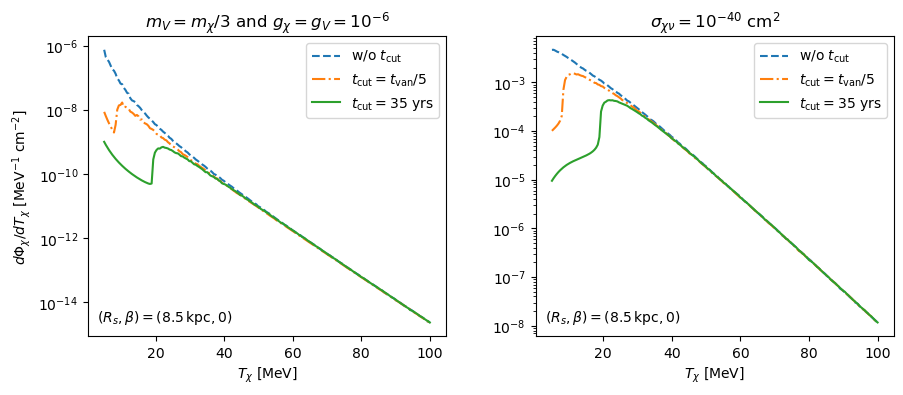

In [93]:
fig = plt.figure(figsize=(8*1.3,3*1.3))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.25)
#fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}~{\rm and}~R_s=8.5\,{\rm kpc}$')
(ax1, ax2) = gs.subplots(sharex='col')

ax1.set_title(r'$m_V=m_\chi/3~{\rm and}~g_\chi=g_V=10^{-6}$')
ax1.plot(Tx_ls,bdmfluxEnergy_no_tvan_cut,'--',label=r'w/o $t_{\rm cut}$')
ax1.plot(Tx_ls,bdmfluxEnergy_vartcut,'-.',label=r'$t_{\rm cut}=t_{\rm van}/5$')
ax1.plot(Tx_ls,bdmfluxEnergy,label=r'$t_{\rm cut}=35$ yrs')
#ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_xlim(6.3e-2,140)
#ax1.set_ylim(4.5e-18,1.3e-12)
ax1.set_ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV$^{-1}$ cm$^{-2}$]')
ax1.set_xlabel(r'$T_\chi$ [MeV]')
ax1.legend()
ax1.text(3, 2.5e-15, r'$(R_s,\beta)=(8.5\,{\rm kpc},0)$')

ax2.set_title(r'$\sigma_{\chi\nu}=10^{-40}~{\rm cm^2}$')
ax2.plot(Tx_ls,np.asarray(bdmfluxEnergy_legacy_no_tvan_cut)*1e5,'--',label=r'w/o $t_{\rm cut}$')
ax2.plot(Tx_ls,np.asarray(bdmfluxEnergy_legacy_vartcut)*1e5,'-.',label=r'$t_{\rm cut}=t_{\rm van}/5$')
ax2.plot(Tx_ls,np.asarray(bdmfluxEnergy_legacy)*1e5,label=r'$t_{\rm cut}=35$ yrs')
#ax1.set_xscale('log')
ax2.set_yscale('log')
#ax1.set_xlim(6.3e-2,140)
#ax1.set_ylim(4.5e-18,1.3e-12)
#ax2.set_ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV$^{-1}$ cm$^{-2}$]')
ax2.set_xlabel(r'$T_\chi$ [MeV]')
ax2.text(3, 1.2e-8, r'$(R_s,\beta)=(8.5\,{\rm kpc},0)$')
ax2.legend()


#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(5.2e-3,210)
#plt.ylim(3.2e-13,1.3e-8)
plt.savefig('../plots/flux_vs_Tx_1MeV.pdf',bbox_inches='tight')


array([ 5.,  8., 11., 14., 17., 20., 23., 26., 29., 32.])

In [198]:
# BDM kinematics
Tx_ls = np.array([5,9,14,20,25,30,50,100])
mx = 1
mV = mx/3
# Rstar
Rstar1 = 8.5
#Rstar2 = 9
#Rstar3 = 5
#Rstar4 = 12
# Off-center angle
beta1 = 0.01
#beta2 = np.pi/10
#beta3 = np.pi/4
#beta4 = np.pi
# Get the vanishing time and maximum theta_M
def flux_t_Tx(t,Tx,mx,mV,thetaM,Rstar,beta,gV,gD,legacy=False):
    # import necessary package
    import vegas
    import numpy as np
    from supernovaNuBoostedDM import diffFluxAtEarth

    #if tvan_cut is not False:
    #    if tvan <= tvan_cut: pass
    #    else: tvan = tvan_cut
    integ = vegas.Integrator([[0, thetaM],[0,2*np.pi]])
    if beta == 0.0:
        neval = 10000
    else:
        neval = 2000
    if legacy is False:
        # body
        try:
            result = integ(lambda x: diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta=x[0],phi=x[1],beta=beta,gV=gV,gD=gD),nitn=10,neval=neval).mean
        except:
            result = 0
    else:
        from bdmLegacy import diffFluxAtEarthLegacy
        # body
        try:
            result = integ(lambda x: diffFluxAtEarthLegacy(t,Tx,mx,Rstar,theta=x[0],phi=x[1],beta=beta,sigxv=1e-45),nitn=10,neval=neval).mean
        except:
            result = 0
    return result


# Setup ipyparallel
cpus = 6
bdm_Tx_ls = []
bdm_Tx_ls_legacy = []
with ipp.Cluster(n = cpus) as rc:
    # get a view on the cluster
    view = rc.load_balanced_view()
    for Tx in Tx_ls:
        tvan,thetaM = get_tvan_thetaM(Tx,1,8.5)
        t_ls = np.logspace(np.log10(yr2s),np.log10(tvan),200) 
    # submit the tasks
        asyncresult = view.map_async(partial(flux_t_Tx,Tx=Tx,mx=mx,mV=mV,thetaM=thetaM,Rstar=Rstar1,beta=beta1,gV=gV,gD=gD,legacy=False), t_ls.tolist())
        asyncresult_legacy = view.map_async(partial(flux_t_Tx,Tx=Tx,mx=mx,mV=mV,thetaM=thetaM,Rstar=Rstar1,beta=beta1,gV=gV,gD=gD,legacy=True), t_ls.tolist())
    # wait interactively for results
        #asyncresult.wait_interactive()
    #asyncresult_no_tvan_cut.wait_interactive()
    #asyncresult_legacy.wait_interactive()
    #asyncresult_legacy_no_tvan_cut.wait_interactive()
    # retrieve actual results
        bdmfluxEnergy = asyncresult.get()
        bdm_Tx_ls.append(bdmfluxEnergy)
        bdmfluxEnergy_legacy = asyncresult_legacy.get()
        bdm_Tx_ls_legacy.append(bdmfluxEnergy_legacy)
    #bdmfluxEnergy_legacy_no_tvan_cut = asyncresult_legacy_no_tvan_cut.get()

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

Stopping engine(s): 1683600596
engine set stopped 1683600596: {'engines': {'0': {'exit_code': 0, 'pid': 10852, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 10853, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 10854, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 10855, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 10856, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 10857, 'identifier': '5'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 10840, 'identifier': 'ipcontroller-1683600595-gls4-7089'}


In [115]:
from matplotlib import cm
from matplotlib.colors import rgb2hex

In [ ]:
cmap = cm.autumn
for i in range(cmap.N):
    rgba = cmap(i)
    print("{}".format(rgb2hex(rgba)))

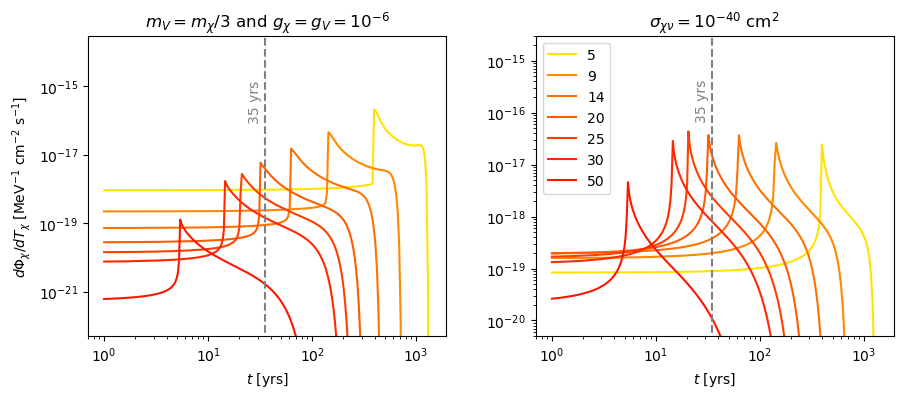

In [200]:
# color setup
cmap = cm.autumn
colors = []
for i in range(len(Tx_ls)-1):
    gray_level = cmap.N*Tx_ls[i]/(Tx_ls[-2]-Tx_ls[0])
    rgba = cmap(int(0.8*gray_level))
    colors.append(rgb2hex(rgba))
colors.reverse()
    
fig = plt.figure(figsize=(8*1.3,3*1.3))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.25)
#fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}~{\rm and}~R_s=8.5\,{\rm kpc}$')
(ax1, ax2) = gs.subplots(sharex='col')

ax1.set_title(r'$m_V=m_\chi/3~{\rm and}~g_\chi=g_V=10^{-6}$')
for i in range(len(Tx_ls)-1):
    tvan,_ = get_tvan_thetaM(Tx_ls[i],1,8.5)
    t_ls = np.logspace(np.log10(yr2s),np.log10(tvan),200)
    ax1.plot(t_ls/yr2s,bdm_Tx_ls[i],color=colors[i],label=f'{Tx_ls[i]}')
ax1.plot([35,35],[1e-26,1e-13],'--',color='gray')
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.legend(loc='upper left')
ax1.set_ylim(5e-23,3e-14)
ax1.set_ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
ax1.set_xlabel(r'$t$ [yrs]')
ax1.text(24, 1e-16, '35 yrs',rotation=90,color='gray')

ax2.set_title(r'$\sigma_{\chi\nu}=10^{-40}~{\rm cm^2}$')
for i in range(len(Tx_ls)-1):
    tvan,_ = get_tvan_thetaM(Tx_ls[i],1,8.5)
    t_ls = np.logspace(np.log10(yr2s),np.log10(tvan),200) 
    ax2.plot(t_ls/yr2s,bdm_Tx_ls_legacy[i],label=f'{Tx_ls[i]}',color=colors[i])
ax2.plot([35,35],[1e-22,1e-14],'--',color='gray')
#ax.legend(loc='upper left')
ax2.set_ylim(1e-20,6e-17)
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax1.set_xlim(6.3e-2,140)
ax2.set_ylim(5e-21,3e-15)
#ax1.set_ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
ax2.set_xlabel(r'$t$ [yrs]')
ax2.text(24, 7.5e-17, '35 yrs',rotation=90,color='gray')
ax2.legend(loc='upper left')

#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(5.2e-3,210)
#plt.ylim(3.2e-13,1.3e-8)
plt.savefig('../plots/flux_vs_t_varTx.pdf',bbox_inches='tight')

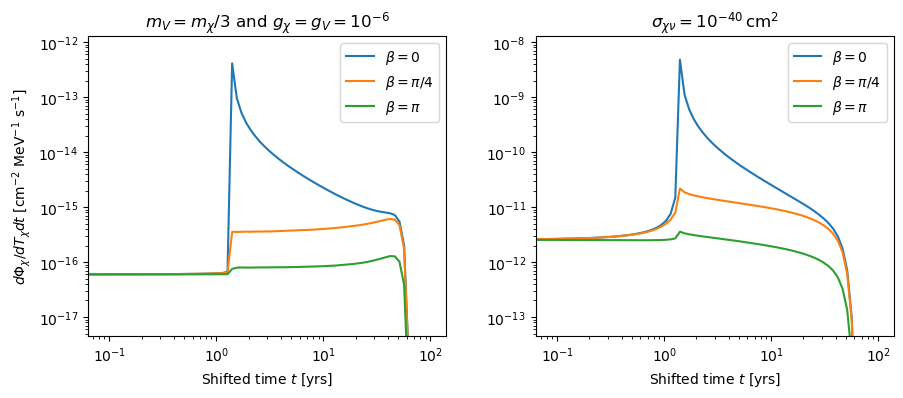

In [6]:
fig = plt.figure(figsize=(8*1.3,3*1.3))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.25)
#fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}~{\rm and}~R_s=8.5\,{\rm kpc}$')
(ax1, ax2) = gs.subplots(sharex='col')

ax1.set_title(r'$m_V=m_\chi/3~{\rm and}~g_\chi=g_V=10^{-6}$')
ax1.plot(time_ls1/yr2s,np.asarray(bdmflux1),label=r'$\beta=0$')
ax1.plot(time_ls1/yr2s,np.asarray(bdmflux2),label=r'$\beta=\pi/4$')
#ax1.plot(time_ls1/yr2s,np.asarray(bdmflux3),label=r'$\beta=\pi/2$')
ax1.plot(time_ls1/yr2s,np.asarray(bdmflux4),label=r'$\beta=\pi$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(6.3e-2,140)
ax1.set_ylim(4.5e-18,1.3e-12)
ax1.set_xlabel(r'Shifted time $t$ [yrs]')
ax1.set_ylabel('$d\Phi_\chi/dT_\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')
ax1.legend()

ax2.set_title(r'$\sigma_{\chi\nu}=10^{-40}\,{\rm cm^2}$')
ax2.plot(time_ls1/yr2s,np.asarray(bdmflux1_legacy)*1e5,label=r'$\beta=0$')
ax2.plot(time_ls1/yr2s,np.asarray(bdmflux2_legacy)*1e5,label=r'$\beta=\pi/4$')
#ax2.plot(time_ls1/yr2s,np.asarray(bdmflux3_legacy)*1e5,label=r'$\beta=\pi/2$')
ax2.plot(time_ls1/yr2s,np.asarray(bdmflux4_legacy)*1e5,label=r'$\beta=\pi$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(6.3e-2,140)
ax2.set_ylim(4.5e-14,1.3e-8)
ax2.set_xlabel(r'Shifted time $t$ [yrs]')
ax2.legend()
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(5.2e-3,210)
#plt.ylim(3.2e-13,1.3e-8)
plt.savefig('../plots/flux_v_beta_comparison.pdf',bbox_inches='tight')

In [2]:
bdmflux1=np.loadtxt('../data/BDM_flux/flux_mx0.1_Tx10_Rs8.5_beta0.00pi.txt',skiprows=1)
bdmflux2=np.loadtxt('../data/BDM_flux/flux_mx0.1_Tx10_Rs8.5_beta0.25pi.txt',skiprows=1)
bdmflux3=np.loadtxt('../data/BDM_flux/flux_mx0.1_Tx10_Rs8.5_beta0.50pi.txt',skiprows=1)

Text(0, 0.5, '$d\\Phi_\\chi/dT_\\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')

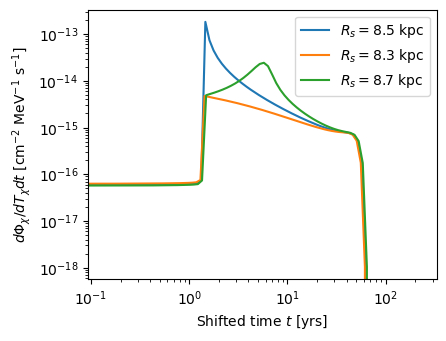

In [37]:
plt.figure(figsize=(4.5,3.5))
plt.plot(bdmflux2.T[0]/yr2s,bdmflux2.T[1],label=r'$R_s=8.5$ kpc')
plt.plot(bdmflux1.T[0]/yr2s,bdmflux1.T[1],label=r'$R_s=8.3$ kpc')
plt.plot(bdmflux3.T[0]/yr2s,bdmflux3.T[1],label=r'$R_s=8.7$ kpc')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(9.3e-2,330)
plt.xlabel(r'Shifted time $t$ [yrs]')
plt.ylabel('$d\Phi_\chi/dT_\chi dt$ [cm$^{-2}$ MeV$^{-1}$ s$^{-1}$]')

In [45]:
# Saving
np.savetxt(f'../data/BDM_flux/Tx{Tx}_mx{mx}_Rs{Rstar1}_beta{beta1}.txt',np.vstack((time_ls1,bdmflux1)).T,fmt = '%.5e  %.5e',header = 'seconds  flux')
np.savetxt(f'../data/BDM_flux/Tx{Tx}_mx{mx}_Rs{Rstar2}_beta{beta2}.txt',np.vstack((time_ls2,bdmflux2)).T,fmt = '%.5e  %.5e',header = 'seconds  flux')
np.savetxt(f'../data/BDM_flux/Tx{Tx}_mx{mx}_Rs{Rstar3}_beta{beta3}.txt',np.vstack((time_ls3,bdmflux3)).T,fmt = '%.5e  %.5e',header = 'seconds  flux')

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 200 and the array at index 1 has size 100

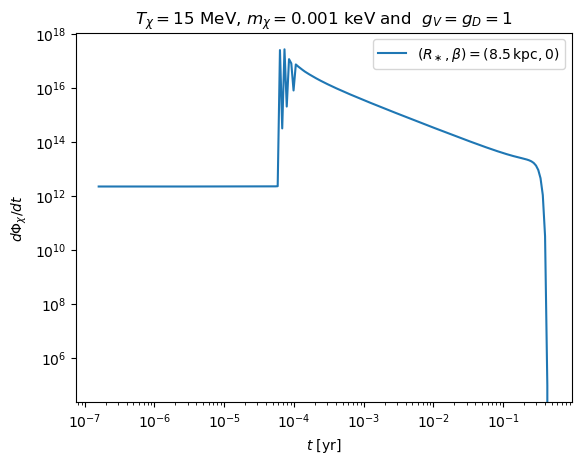

In [48]:
plt.plot(time_ls1/yr2s,bdmflux1 ,label=r'$(R_\ast,\beta)=(8.5\,{\rm kpc},0)$')
plt.plot(time_ls2/yr2s,bdmflux2 ,label=r'$(R_\ast,\beta)=(17\,{\rm kpc},0)$')
plt.plot(time_ls2/yr2s,bdmflux3 ,label=r'$(R_\ast,\beta)=(17\,{\rm kpc},\pi/2)$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$ [yr]')
plt.ylabel(r'$d\Phi_\chi/dt$')
plt.title(f'$T_\chi = {Tx}$ MeV, $m_\chi = {mx}$ keV and ' + ' $g_V=g_D=1$')
plt.legend()
#plt.ylim(1e-20)
#plt.savefig('flux_4.pdf',bbox_inches='tight')

## Total event rate

In [10]:
def totEvent(mx,Rstar,beta,gV=1,gD=1,eps=1,Tx_min=5,Tx_max=100,r_cut=1e-3):
    # import necessary package
    import vegas
    import numpy as np
    from supernovaNuBoostedDM import diffEventRateAtDetector,get_tvan_thetaM
    from constants import yr2s
    # Get vanishing and thetaMax
    tvan,thetaM = get_tvan_thetaM(Tx_min,mx,Rstar)
    # truncate vanishing time
    if tvan <= 35*yr2s:
        pass
    else:
        tvan = 35*yr2s
    # instance for vegas integration
    integ = vegas.Integrator([[10,tvan],[Tx_min,Tx_max],[0,thetaM],[0,2*np.pi]])
    # get acuurate estimation for beta=0
    if beta == 0.0:
        neval = 15000
    else:
        neval = 2500
    # case for zero-kinetic mixing
    if eps == 0.0:
        eps = 1/70
    else: pass
    # body
    try:
        result = integ(lambda x: diffEventRateAtDetector(x[0],x[1],mx,mx,Rstar,theta=x[2],phi=x[3],beta=beta,r_cut=r_cut,gV=gV,gD=gD,eps=eps),nitn=10,neval=neval).mean
    except:
        result = np.nan
    return result

In [205]:
Rstar = 8.5
beta_list = [0,1]
mxList = np.logspace(-6,1,50)
# minimum threshold energy
Tx_min = 5
# Kinetic mixing
eps = 0
# start parallelizing
# cpu numbers
cpus = 6
with ipp.Cluster(n = cpus) as rc:
    # monitoring
    view = rc.load_balanced_view()
    for beta in beta_list:
        # calculation starts here
        asyncresult = view.map_async(partial(totEvent,Rstar=Rstar,beta=beta*np.pi,eps=eps,Tx_min=Tx_min), mxList)
        asyncresult.wait_interactive()
        bdmEvent = asyncresult.get()
        # saving
        np.savetxt(f'../data/BDM_events_Tx_min_5MeV/event_eps{eps}_Rstar{Rstar:.1f}_beta{beta}pi.txt',np.vstack((mxList,bdmEvent)).T,fmt='%.5e   %.5e')

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

functools.partial(<function totEvent at 0x7fbb501f9ee0>, Rstar=8.5, beta=0.0, eps=0, Tx_min=5):   0%|         …

functools.partial(<function totEvent at 0x7fbb501f9ee0>, Rstar=8.5, beta=3.141592653589793, eps=0, Tx_min=5): …

Stopping engine(s): 1683615482
engine set stopped 1683615482: {'engines': {'0': {'exit_code': 0, 'pid': 15140, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 15141, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 15142, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 15143, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 15144, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 15145, 'identifier': '5'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 15128, 'identifier': 'ipcontroller-1683615481-u7do-7089'}


6.567624596571268e-24

In [43]:
def tp(Tx,mx,Rstar):
    Rstar = Rstar*kpc2cm
    vx=np.sqrt(Tx*(2*mx+Tx))*lightSpeed/(mx+Tx)
    tv = Rstar/lightSpeed
    return Rstar/vx - tv

def tp_approx(Tx,mx,Rstar):
    Rstar=Rstar*kpc2cm
    return 0.5*(mx/Tx)**2*Rstar/lightSpeed

def tvan_approx(Tx,mx,Rstar):
    Rstar=Rstar*kpc2cm
    return mx/Tx/4*Rstar/lightSpeed

In [44]:
mass_ls = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
mass_cont_ls = np.logspace(-6,1,50)

tp_ls = []
tp_approx_ls = []
tvan_ls = []
tvan_approx_ls = []

Tx = 20
Rs = 10

for mx in mass_cont_ls:
    tp_approx_ls.append(tp_approx(Tx,mx,Rs)/yr2s)
    tvan_approx_ls.append(tvan_approx(Tx,mx,Rs)/yr2s)
    
for mx in mass_ls:
    tp_ls.append(tp(Tx,mx,Rs)/yr2s)
    tvan_ls.append(get_tvan_thetaM(Tx,mx,Rs)[0]/yr2s)

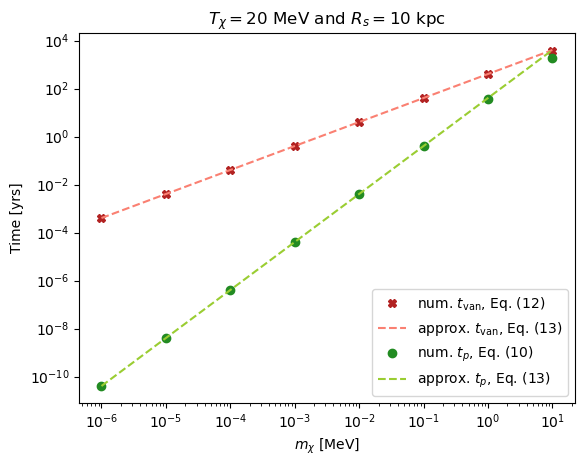

In [57]:
plt.plot(mass_ls,tvan_ls,'X',color='firebrick',label=r'num. $t_{\rm van}$, Eq. (12)')
plt.plot(mass_cont_ls,tvan_approx_ls,'--',color='salmon',label=r'approx. $t_{\rm van}$, Eq. (13)')
plt.plot(mass_ls,tp_ls,'o',color='forestgreen',label=r'num. $t_p$, Eq. (10)')
plt.plot(mass_cont_ls,tp_approx_ls,'--',color='yellowgreen',label=r'approx. $t_p$, Eq. (13)')

plt.legend(loc='lower right')
plt.title(r'$T_\chi=20$ MeV and $R_s=10$ kpc')
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel('Time [yrs]')
plt.xscale('log')
plt.yscale('log')
plt.savefig('../plots/tp_tvan.pdf',bbox_inches='tight')

In [30]:
tp(10,0.01,8.5),tp_approx(10,0.01,8.5)

(436567.0383300781, 437440.2814809411)

In [13]:
tvan_approx(10,0.01,8.5),get_tvan_thetaM(10,0.01,8.5)

(218720140.7404706, (218692807.55562103, 0.044691581036346704))

## Event rate at different angle

In [3]:
# setup function for ipyparallel
# the function is completely independent of this notebook
# everything required should be imported again within function body
def eventToF(thetaBound,tvan,mx,mV,Rstar,beta,legacy=False):
    # import necessary package
    import vegas
    import numpy as np
    integ = vegas.Integrator([[10,tvan],[25,100],thetaBound,[0,2*np.pi]])
    if legacy is False:
        from supernovaNuBoostedDM import diffEventRateAtDetector
        # body
        try:
            result = integ(lambda x: diffEventRateAtDetector(x[0],x[1],mx,mV,Rstar,theta=x[2],phi=x[3],beta=beta),nitn=10,neval=10000).mean
            #exit_code = 0
        except:
            result = np.nan
            #exit_code = 1
    else:
        from bdmLegacy import diffFluxAtEarthLegacy
        try:
            result = integ(lambda x: diffFluxAtEarthLegacy(x[0],x[1],mx,Rstar,theta=x[2],phi=x[3],beta=beta,sigxv=1e-45),nitn=10,neval=10000).mean
        except:
            result = np.nan
    return result#,exit_code


In [4]:
# Generate theta bound
cosThetaBinWidth = 0.01
# theta list, reversed to reflect small to large angles
thetaBound = []
cosList = np.append(np.arange(0.5,1,cosThetaBinWidth),[1])
thetaList = np.flip(np.arccos(cosList))
for i in range(int(0.5/cosThetaBinWidth)):
    thetaBound.append(thetaList[i:i+2].tolist())

In [8]:
# cpu num
cpus = 6
# basic setup
mx_ls = [10,1,1e-1,1e-2]
#mV = mx
Rstar = 8.5
beta = 0.5
# is legacy?
#legacy = False
#bdmEvent = []
#i=1
with ipp.Cluster(n = cpus) as rc:
    
    view = rc.load_balanced_view()
    for mx in mx_ls:
        mV = mx/3
        tvan,_ = get_tvan_thetaM(5,mx,Rstar)
        if tvan > 35*yr2s: tvan = 35*yr2s
        # submit the tasks
        asyncresult = view.map_async(partial(eventToF,tvan=tvan,mx=mx,mV=mV,Rstar=Rstar,beta=beta*np.pi,legacy=False), thetaBound)
        asyncresultLegacy = view.map_async(partial(eventToF,tvan=tvan,mx=mx,mV=mV,Rstar=Rstar,beta=beta*np.pi,legacy=True), thetaBound)
        # wait interactively for results
        asyncresult.wait_interactive()
        asyncresultLegacy.wait_interactive()
        # retrieve actual results
        bdmEvent = asyncresult.get()
        bdmEventLegacy = asyncresultLegacy.get()
        #print(f'{100*i/90:.3f}% completed!',end='\r')
        #i+=1
        # saving
        np.save(f'../data/BDM_events/bdmBinCosEvent_mx{mx}_Rstar{Rstar}_beta{beta}pi',bdmEvent)
        np.save(f'../data/BDM_events/bdmBinCosLegacyEvent_mx{mx}_Rstar{Rstar}_beta{beta}pi',bdmEventLegacy)

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

functools.partial(<function eventToF at 0x7f7b288db5e0>, tvan=1103760000, mx=10, mV=3.3333333333333335, Rstar=…

functools.partial(<function eventToF at 0x7f7b288db5e0>, tvan=1103760000, mx=10, mV=3.3333333333333335, Rstar=…

functools.partial(<function eventToF at 0x7f7b288db5e0>, tvan=1103760000, mx=1, mV=0.3333333333333333, Rstar=8…

functools.partial(<function eventToF at 0x7f7b288db5e0>, tvan=1103760000, mx=1, mV=0.3333333333333333, Rstar=8…

functools.partial(<function eventToF at 0x7f7b288db5e0>, tvan=1103760000, mx=0.1, mV=0.03333333333333333, Rsta…

functools.partial(<function eventToF at 0x7f7b288db5e0>, tvan=1103760000, mx=0.1, mV=0.03333333333333333, Rsta…

functools.partial(<function eventToF at 0x7f7b288db5e0>, tvan=437330976.05645406, mx=0.01, mV=0.00333333333333…

functools.partial(<function eventToF at 0x7f7b288db5e0>, tvan=437330976.05645406, mx=0.01, mV=0.00333333333333…

Stopping engine(s): 1683253014
engine set stopped 1683253014: {'engines': {'0': {'exit_code': 0, 'pid': 58866, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 58874, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 58875, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 58876, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 58877, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 58878, 'identifier': '5'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 58861, 'identifier': 'ipcontroller-1683253013-09gn-58320'}


In [9]:
# model-dependent
eventBinCosMx10Beta0 = np.load(f'../data/BDM_events/bdmBinCosEvent_mx10_Rstar8.5_beta0pi.npy')
eventBinCosMx1Beta0 = np.load(f'../data/BDM_events/bdmBinCosEvent_mx1_Rstar8.5_beta0pi.npy')
eventBinCosMx01Beta0 = np.load(f'../data/BDM_events/bdmBinCosEvent_mx0.1_Rstar8.5_beta0pi.npy')
eventBinCosMx001Beta0 = np.load(f'../data/BDM_events/bdmBinCosEvent_mx0.01_Rstar8.5_beta0pi.npy')
eventBinCosMx10BetaQuarter = np.load(f'../data/BDM_events/bdmBinCosEvent_mx10_Rstar8.5_beta0.25pi.npy')
eventBinCosMx1BetaQuarter = np.load(f'../data/BDM_events/bdmBinCosEvent_mx1_Rstar8.5_beta0.25pi.npy')
eventBinCosMx01BetaQuarter = np.load(f'../data/BDM_events/bdmBinCosEvent_mx0.1_Rstar8.5_beta0.25pi.npy')
eventBinCosMx001BetaQuarter = np.load(f'../data/BDM_events/bdmBinCosEvent_mx0.01_Rstar8.5_beta0.25pi.npy')
eventBinCosMx10BetaHalf = np.load(f'../data/BDM_events/bdmBinCosEvent_mx10_Rstar8.5_beta0.5pi.npy')
eventBinCosMx1BetaHalf = np.load(f'../data/BDM_events/bdmBinCosEvent_mx1_Rstar8.5_beta0.5pi.npy')
eventBinCosMx01BetaHalf = np.load(f'../data/BDM_events/bdmBinCosEvent_mx0.1_Rstar8.5_beta0.5pi.npy')
eventBinCosMx001BetaHalf = np.load(f'../data/BDM_events/bdmBinCosEvent_mx0.01_Rstar8.5_beta0.5pi.npy')
eventBinCosMx10BetaPi = np.load(f'../data/BDM_events/bdmBinCosEvent_mx10_Rstar8.5_beta1pi.npy')
eventBinCosMx1BetaPi = np.load(f'../data/BDM_events/bdmBinCosEvent_mx1_Rstar8.5_beta1pi.npy')
eventBinCosMx01BetaPi = np.load(f'../data/BDM_events/bdmBinCosEvent_mx0.1_Rstar8.5_beta1pi.npy')
eventBinCosMx001BetaPi = np.load(f'../data/BDM_events/bdmBinCosEvent_mx0.01_Rstar8.5_beta1pi.npy')
# model-agnostic
eventBinCosLegacyMx10Beta0 = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx10_Rstar8.5_beta0pi.npy')
eventBinCosLegacyMx1Beta0 = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx1_Rstar8.5_beta0pi.npy')
eventBinCosLegacyMx01Beta0 = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx0.1_Rstar8.5_beta0pi.npy')
eventBinCosLegacyMx001Beta0 = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx0.01_Rstar8.5_beta0pi.npy')
eventBinCosLegacyMx10BetaQuarter = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx10_Rstar8.5_beta0.25pi.npy')
eventBinCosLegacyMx1BetaQuarter = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx1_Rstar8.5_beta0.25pi.npy')
eventBinCosLegacyMx01BetaQuarter = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx0.1_Rstar8.5_beta0.25pi.npy')
eventBinCosLegacyMx001BetaQuarter = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx0.01_Rstar8.5_beta0.25pi.npy')
eventBinCosLegacyMx10BetaHalf = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx10_Rstar8.5_beta0.5pi.npy')
eventBinCosLegacyMx1BetaHalf = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx1_Rstar8.5_beta0.5pi.npy')
eventBinCosLegacyMx01BetaHalf = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx0.1_Rstar8.5_beta0.5pi.npy')
eventBinCosLegacyMx001BetaHalf = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx0.01_Rstar8.5_beta0.5pi.npy')
eventBinCosLegacyMx10BetaPi = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx10_Rstar8.5_beta1pi.npy')
eventBinCosLegacyMx1BetaPi = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx1_Rstar8.5_beta1pi.npy')
eventBinCosLegacyMx01BetaPi = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx0.1_Rstar8.5_beta1pi.npy')
eventBinCosLegacyMx001BetaPi = np.load(f'../data/BDM_events/bdmBinCosLegacyEvent_mx0.01_Rstar8.5_beta1pi.npy')

In [11]:
Rstar = 8.5
NeSK = 7.473e33 # SK total electron number
# model-dependent
gV = 1e-3 #1e-5
gD = 1e-3 #1e-2
eps = gV # 1e-5
efficiency = 0.5
totalEffect = NeSK*gV**2*gD**4*eps**2*efficiency 
# model-independent
sigxv = 1e-33
sigxe = 1e-33
totalEffectLegacy = efficiency*NeSK*sigxe*sigxv/1e-45
# Max theta theoretical prediction
_,thetaM_mx10 = get_tvan_thetaM(25,10,Rstar)
_,thetaM_mx1 = get_tvan_thetaM(25,1,Rstar)
_,thetaM_mx01 = get_tvan_thetaM(25,1e-1,Rstar)
_,thetaM_mx001 = get_tvan_thetaM(25,1e-2,Rstar)

Text(0.5, 1.0, '$\\sigma_{\\chi\\nu}=\\sigma_{\\chi e}=10^{-33}\\,{\\rm cm^2}$')

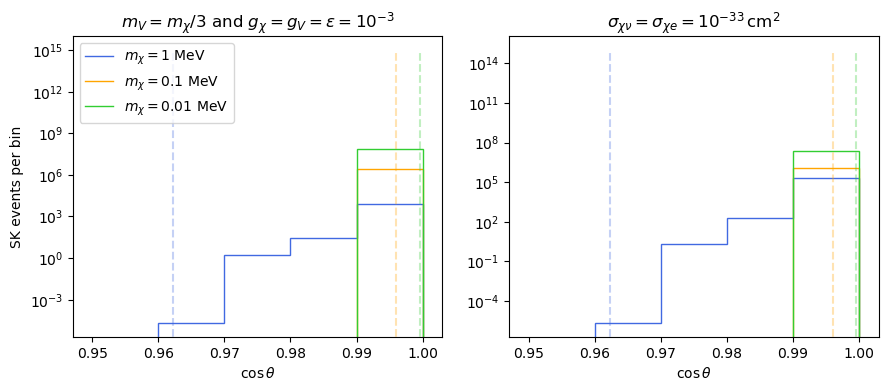

In [25]:
fig = plt.figure(figsize=(8*1.3,3*1.3))
gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0.18)
#fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}~{\rm and}~R_s=8.5\,{\rm kpc}$')
(ax1, ax2) = gs.subplots(sharex='col')

ax1.stairs(eventBinCosMx1Beta0*totalEffect,np.cos(thetaList),color='royalblue',label=r'$m_\chi=1$ MeV')
ax1.stairs(eventBinCosMx01Beta0*totalEffect,np.cos(thetaList),color='orange',label=r'$m_\chi=0.1$ MeV')
ax1.stairs(eventBinCosMx001Beta0*totalEffect,np.cos(thetaList),color='limegreen',label=r'$m_\chi=0.01$ MeV')
# theta max
ax1.plot([np.cos(thetaM_mx1)]*2,[0,1e15],'--',alpha=0.3,color='royalblue')
ax1.plot([np.cos(thetaM_mx01)]*2,[0,1e15],'--',alpha=0.3,color='orange')
ax1.plot([np.cos(thetaM_mx001)]*2,[0,1e15],'--',alpha=0.3,color='limegreen')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90)
#ax1.text(0.8-0.016, 0.3, r'$(R_s,\beta)=(8.5\,{\rm kpc},0)$',horizontalalignment='left')
ax1.legend(loc='upper left')
ax1.set_yscale('log')
ax1.set_xlim(0.947,1.003)
#ax1.set_ylim(5e-2,3e12)
ax1.set_xlabel(r'$\cos\theta$')
ax1.set_ylabel(r'SK events per bin')
ax1.set_title(r'$m_V= m_\chi/3$ and $g_\chi=g_V=\epsilon=10^{-3}$')

ax2.stairs(eventBinCosLegacyMx1Beta0*totalEffectLegacy,np.cos(thetaList),color='royalblue',label=r'$m_\chi=1$ MeV')
ax2.stairs(eventBinCosLegacyMx01Beta0*totalEffectLegacy,np.cos(thetaList),color='orange',label=r'$m_\chi=0.1$ MeV')
ax2.stairs(eventBinCosLegacyMx001Beta0*totalEffectLegacy,np.cos(thetaList),color='limegreen',label=r'$m_\chi=0.01$ MeV')
# theta max
ax2.plot([np.cos(thetaM_mx1)]*2,[0,1e15],'--',alpha=0.3,color='royalblue')
ax2.plot([np.cos(thetaM_mx01)]*2,[0,1e15],'--',alpha=0.3,color='orange')
ax2.plot([np.cos(thetaM_mx001)]*2,[0,1e15],'--',alpha=0.3,color='limegreen')
#plt.plot([np.cos(thetaM_mx1)]*2,[0,2*np.max(eventBinCosMx1Beta0*totalEffect)],'--',color='grey')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90
#ax2.text(0.8-0.013, 5e8, r'$(R_s,\beta)=(8.5\,{\rm kpc},0)$',horizontalalignment='left')
#ax2.legend(loc='upper left')
ax2.set_yscale('log')
ax2.set_xlim(0.947,1.003)
#ax2.set_ylim(5e-1,3e9)
ax2.set_xlabel(r'$\cos\theta$')
#ax2.set_ylabel(r'SK events per bin')
ax2.set_title(r'$\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-33}\,{\rm cm^2}$')
#plt.savefig('../plots/eventPerBinBeta0.pdf',bbox_inches='tight')

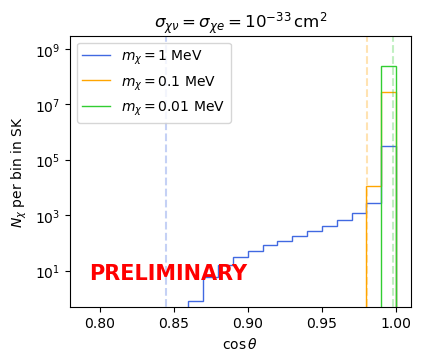

In [44]:
plt.figure(figsize=(4*1.1,3.2*1.1))
plt.stairs(eventBinCosLegacyMx1Beta0*totalEffectLegacy,np.cos(thetaList),color='royalblue',label=r'$m_\chi=1$ MeV')
plt.stairs(eventBinCosLegacyMx01Beta0*totalEffectLegacy,np.cos(thetaList),color='orange',label=r'$m_\chi=0.1$ MeV')
plt.stairs(eventBinCosLegacyMx001Beta0*totalEffectLegacy,np.cos(thetaList),color='limegreen',label=r'$m_\chi=0.01$ MeV')
# theta max
plt.plot([np.cos(thetaM_mx1)]*2,[0,1e15],'--',alpha=0.3,color='royalblue')
plt.plot([np.cos(thetaM_mx01)]*2,[0,1e15],'--',alpha=0.3,color='orange')
plt.plot([np.cos(thetaM_mx001)]*2,[0,1e15],'--',alpha=0.3,color='limegreen')
plt.legend()
#plt.plot([np.cos(thetaM_mx1)]*2,[0,2*np.max(eventBinCosMx1Beta0*totalEffect)],'--',color='grey')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90
plt.text(0.793, 5, r'PRELIMINARY',horizontalalignment='left',size=15,color='red', weight='bold')
#ax2.legend(loc='upper left')
plt.yscale('log')
plt.xlim(0.8-0.02,1.01)
plt.ylim(5e-1,3e9)
plt.xlabel(r'$\cos\theta$')
plt.ylabel(r'$N_\chi$ per bin in SK')
plt.title(r'$\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-33}\,{\rm cm^2}$')
plt.savefig('../npc_proposal.pdf',bbox_inches='tight')

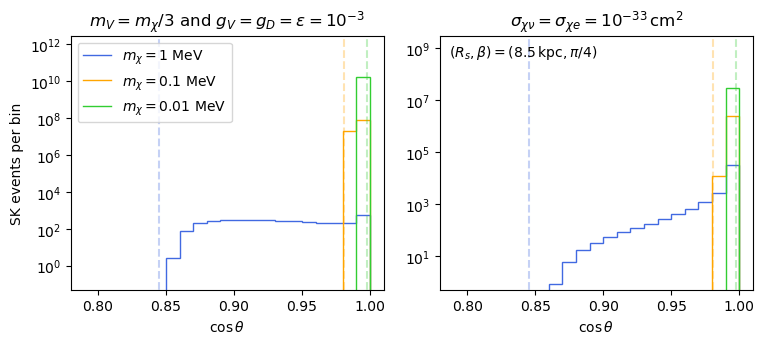

In [296]:
fig = plt.figure(figsize=(8*1.1,3*1.1))
gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0.18)
#fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}~{\rm and}~R_s=8.5\,{\rm kpc}$')
(ax1, ax2) = gs.subplots(sharex='col')

ax1.stairs(eventBinCosMx1BetaQuarter*totalEffect,np.cos(thetaList),color='royalblue',label=r'$m_\chi=1$ MeV')
ax1.stairs(eventBinCosMx01BetaQuarter*totalEffect,np.cos(thetaList),color='orange',label=r'$m_\chi=0.1$ MeV')
ax1.stairs(eventBinCosMx001BetaQuarter*totalEffect,np.cos(thetaList),color='limegreen',label=r'$m_\chi=0.01$ MeV')
# theta max
ax1.plot([np.cos(thetaM_mx1)]*2,[0,1e15],'--',alpha=0.3,color='royalblue')
ax1.plot([np.cos(thetaM_mx01)]*2,[0,1e15],'--',alpha=0.3,color='orange')
ax1.plot([np.cos(thetaM_mx001)]*2,[0,1e15],'--',alpha=0.3,color='limegreen')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90)
#ax1.text(0.8-0.016, 0.3, r'$(R_s,\beta)=(8.5\,{\rm kpc},0)$',horizontalalignment='left')
ax1.legend(loc='upper left')
ax1.set_yscale('log')
ax1.set_xlim(0.8-0.02,1.01)
ax1.set_ylim(5e-2,3e12)
ax1.set_xlabel(r'$\cos\theta$')
ax1.set_ylabel(r'SK events per bin')
ax1.set_title(r'$m_V=m_\chi/3$ and $g_V=g_D=\epsilon=10^{-3}$')

ax2.stairs(eventBinCosLegacyMx1BetaQuarter*totalEffectLegacy,np.cos(thetaList),color='royalblue',label=r'$m_\chi=1$ MeV')
ax2.stairs(eventBinCosLegacyMx01BetaQuarter*totalEffectLegacy,np.cos(thetaList),color='orange',label=r'$m_\chi=0.1$ MeV')
ax2.stairs(eventBinCosLegacyMx001BetaQuarter*totalEffectLegacy,np.cos(thetaList),color='limegreen',label=r'$m_\chi=0.01$ MeV')
# theta max
ax2.plot([np.cos(thetaM_mx1)]*2,[0,1e15],'--',alpha=0.3,color='royalblue')
ax2.plot([np.cos(thetaM_mx01)]*2,[0,1e15],'--',alpha=0.3,color='orange')
ax2.plot([np.cos(thetaM_mx001)]*2,[0,1e15],'--',alpha=0.3,color='limegreen')
#plt.plot([np.cos(thetaM_mx1)]*2,[0,2*np.max(eventBinCosMx1Beta0*totalEffect)],'--',color='grey')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90
ax2.text(0.8-0.013, 5e8, r'$(R_s,\beta)=(8.5\,{\rm kpc},\pi/4)$',horizontalalignment='left')
#ax2.legend(loc='upper left')
ax2.set_yscale('log')
ax2.set_xlim(0.8-0.02,1.01)
ax2.set_ylim(5e-1,3e9)
ax2.set_xlabel(r'$\cos\theta$')
#ax2.set_ylabel(r'SK events per bin')
ax2.set_title(r'$\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-33}\,{\rm cm^2}$')
plt.savefig('../plots/eventPerBinBeta0.25pi.pdf',bbox_inches='tight')

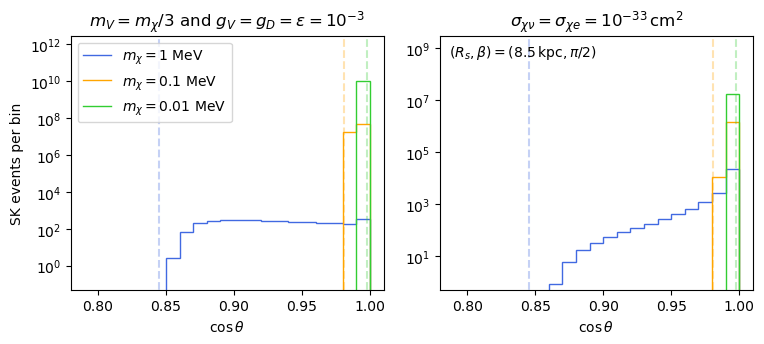

In [300]:
fig = plt.figure(figsize=(8*1.1,3*1.1))
gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0.18)
#fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}~{\rm and}~R_s=8.5\,{\rm kpc}$')
(ax1, ax2) = gs.subplots(sharex='col')

ax1.stairs(eventBinCosMx1BetaHalf*totalEffect,np.cos(thetaList),color='royalblue',label=r'$m_\chi=1$ MeV')
ax1.stairs(eventBinCosMx01BetaHalf*totalEffect,np.cos(thetaList),color='orange',label=r'$m_\chi=0.1$ MeV')
ax1.stairs(eventBinCosMx001BetaHalf*totalEffect,np.cos(thetaList),color='limegreen',label=r'$m_\chi=0.01$ MeV')
# theta max
ax1.plot([np.cos(thetaM_mx1)]*2,[0,1e15],'--',alpha=0.3,color='royalblue')
ax1.plot([np.cos(thetaM_mx01)]*2,[0,1e15],'--',alpha=0.3,color='orange')
ax1.plot([np.cos(thetaM_mx001)]*2,[0,1e15],'--',alpha=0.3,color='limegreen')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90)
#ax1.text(0.8-0.016, 0.3, r'$(R_s,\beta)=(8.5\,{\rm kpc},0)$',horizontalalignment='left')
ax1.legend(loc='upper left')
ax1.set_yscale('log')
ax1.set_xlim(0.8-0.02,1.01)
ax1.set_ylim(5e-2,3e12)
ax1.set_xlabel(r'$\cos\theta$')
ax1.set_ylabel(r'SK events per bin')
ax1.set_title(r'$m_V=m_\chi/3$ and $g_V=g_D=\epsilon=10^{-3}$')

ax2.stairs(eventBinCosLegacyMx1BetaHalf*totalEffectLegacy,np.cos(thetaList),color='royalblue',label=r'$m_\chi=1$ MeV')
ax2.stairs(eventBinCosLegacyMx01BetaHalf*totalEffectLegacy,np.cos(thetaList),color='orange',label=r'$m_\chi=0.1$ MeV')
ax2.stairs(eventBinCosLegacyMx001BetaHalf*totalEffectLegacy,np.cos(thetaList),color='limegreen',label=r'$m_\chi=0.01$ MeV')
# theta max
ax2.plot([np.cos(thetaM_mx1)]*2,[0,1e15],'--',alpha=0.3,color='royalblue')
ax2.plot([np.cos(thetaM_mx01)]*2,[0,1e15],'--',alpha=0.3,color='orange')
ax2.plot([np.cos(thetaM_mx001)]*2,[0,1e15],'--',alpha=0.3,color='limegreen')
#plt.plot([np.cos(thetaM_mx1)]*2,[0,2*np.max(eventBinCosMx1Beta0*totalEffect)],'--',color='grey')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90
ax2.text(0.8-0.013, 5e8, r'$(R_s,\beta)=(8.5\,{\rm kpc},\pi/2)$',horizontalalignment='left')
#ax2.legend(loc='upper left')
ax2.set_yscale('log')
ax2.set_xlim(0.8-0.02,1.01)
ax2.set_ylim(5e-1,3e9)
ax2.set_xlabel(r'$\cos\theta$')
#ax2.set_ylabel(r'SK events per bin')
ax2.set_title(r'$\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-33}\,{\rm cm^2}$')
plt.savefig('../plots/eventPerBinBeta0.5pi.pdf',bbox_inches='tight')

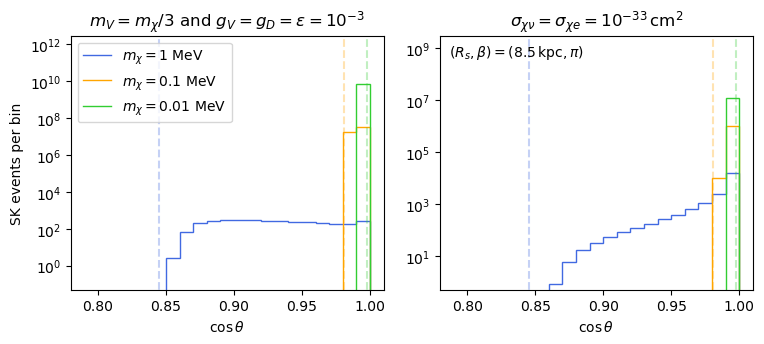

In [304]:
fig = plt.figure(figsize=(8*1.1,3*1.1))
gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0.18)
#fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}~{\rm and}~R_s=8.5\,{\rm kpc}$')
(ax1, ax2) = gs.subplots(sharex='col')

ax1.stairs(eventBinCosMx1BetaPi*totalEffect,np.cos(thetaList),color='royalblue',label=r'$m_\chi=1$ MeV')
ax1.stairs(eventBinCosMx01BetaPi*totalEffect,np.cos(thetaList),color='orange',label=r'$m_\chi=0.1$ MeV')
ax1.stairs(eventBinCosMx001BetaPi*totalEffect,np.cos(thetaList),color='limegreen',label=r'$m_\chi=0.01$ MeV')
# theta max
ax1.plot([np.cos(thetaM_mx1)]*2,[0,1e15],'--',alpha=0.3,color='royalblue')
ax1.plot([np.cos(thetaM_mx01)]*2,[0,1e15],'--',alpha=0.3,color='orange')
ax1.plot([np.cos(thetaM_mx001)]*2,[0,1e15],'--',alpha=0.3,color='limegreen')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90)
#ax1.text(0.8-0.016, 0.3, r'$(R_s,\beta)=(8.5\,{\rm kpc},0)$',horizontalalignment='left')
ax1.legend(loc='upper left')
ax1.set_yscale('log')
ax1.set_xlim(0.8-0.02,1.01)
ax1.set_ylim(5e-2,3e12)
ax1.set_xlabel(r'$\cos\theta$')
ax1.set_ylabel(r'SK events per bin')
ax1.set_title(r'$m_V=m_\chi/3$ and $g_V=g_D=\epsilon=10^{-3}$')

ax2.stairs(eventBinCosLegacyMx1BetaPi*totalEffectLegacy,np.cos(thetaList),color='royalblue',label=r'$m_\chi=1$ MeV')
ax2.stairs(eventBinCosLegacyMx01BetaPi*totalEffectLegacy,np.cos(thetaList),color='orange',label=r'$m_\chi=0.1$ MeV')
ax2.stairs(eventBinCosLegacyMx001BetaPi*totalEffectLegacy,np.cos(thetaList),color='limegreen',label=r'$m_\chi=0.01$ MeV')
# theta max
ax2.plot([np.cos(thetaM_mx1)]*2,[0,1e15],'--',alpha=0.3,color='royalblue')
ax2.plot([np.cos(thetaM_mx01)]*2,[0,1e15],'--',alpha=0.3,color='orange')
ax2.plot([np.cos(thetaM_mx001)]*2,[0,1e15],'--',alpha=0.3,color='limegreen')
#plt.plot([np.cos(thetaM_mx1)]*2,[0,2*np.max(eventBinCosMx1Beta0*totalEffect)],'--',color='grey')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90
ax2.text(0.8-0.013, 5e8, r'$(R_s,\beta)=(8.5\,{\rm kpc},\pi)$',horizontalalignment='left')
#ax2.legend(loc='upper left')
ax2.set_yscale('log')
ax2.set_xlim(0.8-0.02,1.01)
ax2.set_ylim(5e-1,3e9)
ax2.set_xlabel(r'$\cos\theta$')
#ax2.set_ylabel(r'SK events per bin')
ax2.set_title(r'$\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-33}\,{\rm cm^2}$')
plt.savefig('../plots/eventPerBinBeta1pi.pdf',bbox_inches='tight')

In [2]:
flux1 = np.load('../data/BDM_flux_angle/bdmFluxTheta_mx1_Rstar8.5_beta0pi.npy')
flux2 = np.load('../data/BDM_flux_angle/bdmFluxTheta_mx0.1_Rstar8.5_beta0pi.npy')
flux3 = np.load('../data/BDM_flux_angle/bdmFluxTheta_mx0.01_Rstar8.5_beta0pi.npy')
flux1leg = np.load('../data/BDM_flux_angle/bdmFluxThetaLegacy_mx1_Rstar8.5_beta0pi.npy')
flux2leg = np.load('../data/BDM_flux_angle/bdmFluxThetaLegacy_mx0.1_Rstar8.5_beta0pi.npy')
flux3leg = np.load('../data/BDM_flux_angle/bdmFluxThetaLegacy_mx0.01_Rstar8.5_beta0pi.npy')

In [5]:
Rstar = 8.5
NeSK = 7.473e33 # SK total electron number
# model-dependent
gV = 1e-6 #1e-5
gD = 1e-6 #1e-2
totalEffect = gV**2*gD**2 
# model-independent
sigxv = 1e-33
sigxe = 1e-33
totalEffectLegacy = 1e-40/1e-45
# Max theta theoretical prediction
_,thetaM_mx10 = get_tvan_thetaM(5,10,Rstar)
_,thetaM_mx1 = get_tvan_thetaM(5,1,Rstar)
_,thetaM_mx01 = get_tvan_thetaM(5,1e-1,Rstar)
_,thetaM_mx001 = get_tvan_thetaM(5,1e-2,Rstar)

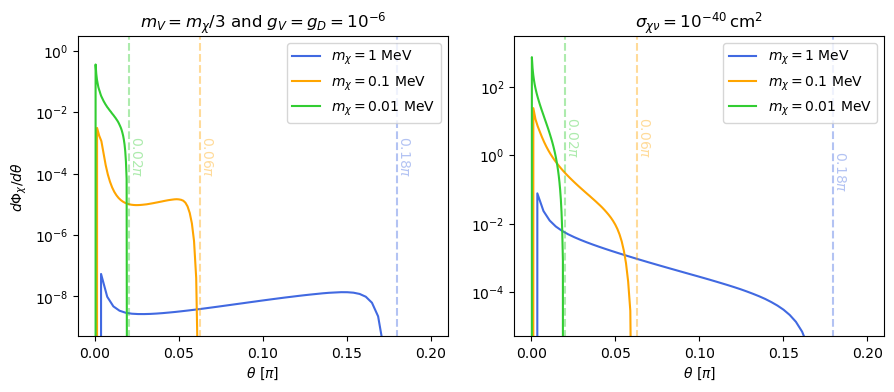

In [21]:
fig = plt.figure(figsize=(8*1.3,3*1.3))
gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0.18)
#fig.suptitle(r'$(m_\chi,T_\chi)=(0.1,10)\,{\rm MeV}~{\rm and}~R_s=8.5\,{\rm kpc}$')
(ax1, ax2) = gs.subplots(sharex='col')


ax1.plot(flux1.T[0]/np.pi,flux1.T[1]*totalEffect,color='royalblue',label=r'$m_\chi=1$ MeV')
ax1.plot(flux2.T[0]/np.pi,flux2.T[1]*totalEffect,color='orange',label=r'$m_\chi=0.1$ MeV')
ax1.plot(flux3.T[0]/np.pi,flux3.T[1]*totalEffect,color='limegreen',label=r'$m_\chi=0.01$ MeV')
ax1.plot([thetaM_mx1/np.pi]*2,[0,1e15],'--',alpha=0.4,color='royalblue')
ax1.plot([thetaM_mx01/np.pi]*2,[0,1e15],'--',alpha=0.4,color='orange')
ax1.plot([thetaM_mx001/np.pi]*2,[0,1e15],'--',alpha=0.4,color='limegreen')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90)
ax1.text(thetaM_mx1/np.pi, 0.0001, r'$0.18\pi$',color='royalblue',alpha=0.4,horizontalalignment='left',rotation=270)
ax1.text(thetaM_mx01/np.pi, 0.0001, r'$0.06\pi$',color='orange',alpha=0.4,horizontalalignment='left',rotation=270)
ax1.text(thetaM_mx001/np.pi, 0.0001, r'$0.02\pi$',color='limegreen',alpha=0.4,horizontalalignment='left',rotation=270)
ax1.legend()
ax1.set_yscale('log')
ax1.set_xlim(-0.01,0.21)
ax1.set_ylim(5e-10,3)
ax1.set_xlabel(r'$\theta~[\pi]$')
ax1.set_ylabel(r'$d\Phi_\chi/d\theta$')
ax1.set_title(r'$m_V=m_\chi/3$ and $g_V=g_D=10^{-6}$')


# theta max
ax2.plot(flux1leg.T[0]/np.pi,flux1leg.T[1]*totalEffectLegacy,color='royalblue',label=r'$m_\chi=1$ MeV')
ax2.plot(flux2leg.T[0]/np.pi,flux2leg.T[1]*totalEffectLegacy,color='orange',label=r'$m_\chi=0.1$ MeV')
ax2.plot(flux3leg.T[0]/np.pi,flux3leg.T[1]*totalEffectLegacy,color='limegreen',label=r'$m_\chi=0.01$ MeV')
ax2.plot([thetaM_mx1/np.pi]*2,[0,1e15],'--',alpha=0.4,color='royalblue')
ax2.plot([thetaM_mx01/np.pi]*2,[0,1e15],'--',alpha=0.4,color='orange')
ax2.plot([thetaM_mx001/np.pi]*2,[0,1e15],'--',alpha=0.4,color='limegreen')
ax2.text(thetaM_mx1/np.pi, 0.1, r'$0.18\pi$',color='royalblue',alpha=0.4,horizontalalignment='left',rotation=270)
ax2.text(thetaM_mx01/np.pi, 1, r'$0.06\pi$',color='orange',alpha=0.4,horizontalalignment='left',rotation=270)
ax2.text(thetaM_mx001/np.pi, 1, r'$0.02\pi$',color='limegreen',alpha=0.4,horizontalalignment='left',rotation=270)
#plt.plot([np.cos(thetaM_mx1)]*2,[0,2*np.max(eventBinCosMx1Beta0*totalEffect)],'--',color='grey')
#plt.text(0.975*np.cos(thetaM_mx1),1.05*np.max(eventBinCosMx1Beta0*totalEffect)/2, r'Theoretically predicted $\cos\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=90
#ax2.text(0.8-0.013, 5e8, r'$(R_s,\beta)=(8.5\,{\rm kpc},\pi)$',horizontalalignment='left')
ax2.legend()
ax2.set_yscale('log')
ax2.set_xlim(-0.01,0.21)
ax2.set_ylim(5e-6,3e3)
ax2.set_xlabel(r'$\theta~[\pi]$')
#ax2.set_ylabel(r'SK events per bin')
ax2.set_title(r'$\sigma_{\chi\nu}=10^{-40}\,{\rm cm^2}$')
plt.savefig('../plots/spectra_v_theta.pdf',bbox_inches='tight')

In [40]:
flux1.T[0]

array([0.        , 0.01150903, 0.02301807, 0.0345271 , 0.04603613,
       0.05754517, 0.0690542 , 0.08056323, 0.09207227, 0.1035813 ,
       0.11509033, 0.12659937, 0.1381084 , 0.14961744, 0.16112647,
       0.1726355 , 0.18414454, 0.19565357, 0.2071626 , 0.21867164,
       0.23018067, 0.2416897 , 0.25319874, 0.26470777, 0.2762168 ,
       0.28772584, 0.29923487, 0.3107439 , 0.32225294, 0.33376197,
       0.345271  , 0.35678004, 0.36828907, 0.37979811, 0.39130714,
       0.40281617, 0.41432521, 0.42583424, 0.43734327, 0.44885231,
       0.46036134, 0.47187037, 0.48337941, 0.49488844, 0.50639747,
       0.51790651, 0.52941554, 0.54092457, 0.55243361, 0.56394264])

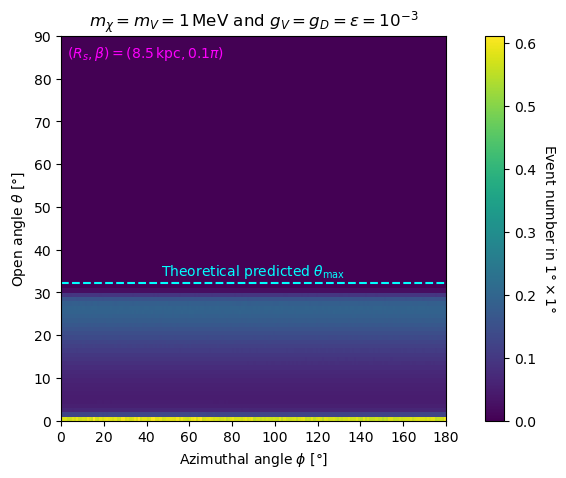

In [62]:
#normpar = get_tvan_thetaMLogNorm()
fig, _ = plt.subplots(figsize = (10,5))
eventplot = plt.imshow(event2*totalEffect, # plot the smearing values as an image, because python
                       # cmap = "CMRmap", # nice colormap
                       cmap = 'viridis',
                       interpolation = 'nearest', # avoid smoothing
                       origin = 'lower', # (0,0) is in the bottom left corner
                       extent = (0, 180, 0, 90), # set axis ranges
                       #norm = normpar, # log scale
                       aspect=2)
plt.plot([0,180],[thetaM*180/np.pi]*2,'--',color='aqua')
plt.text(90, 1.05*thetaM*180/np.pi, r'Theoretical predicted $\theta_{\rm max}$',color='aqua',horizontalalignment='center')
plt.text(3, 85, r'$(R_s,\beta)=(8.5\,{\rm kpc},0.1\pi)$',color='magenta',horizontalalignment='left')

plt.title(r'$m_\chi=m_V=1\,{\rm MeV}$ and $g_V=g_D=\epsilon=10^{-3}$')
plt.xlabel(r'Azimuthal angle $\phi~[\degree]$')
#plt.xticks( fontsize = 20 )
plt.ylabel(r'Open angle $\theta~[\degree]$')
#plt.yticks( fontsize = 20 )
cbar = plt.colorbar(eventplot)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'Event number in $1\degree \times 1\degree$', rotation=270)
plt.savefig('../plots/eventPhixTheta_beta0.1pi.pdf',bbox_inches='tight')
#plt.show()

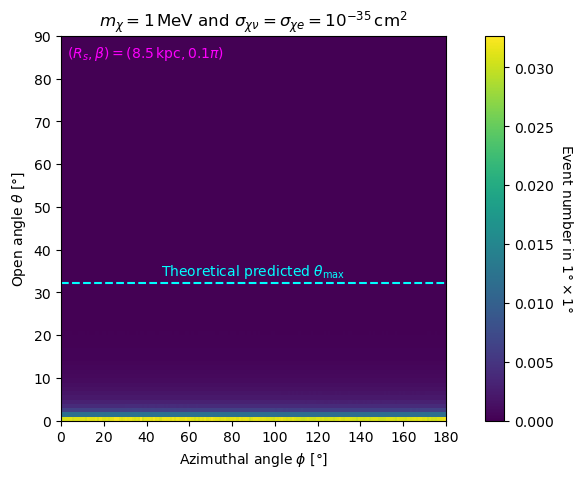

In [63]:
fig, _ = plt.subplots(figsize = (10,5))
eventplot = plt.imshow(event6*totalEffectLegacy, # plot the smearing values as an image, because python
                       # cmap = "CMRmap", # nice colormap
                       cmap = 'viridis',
                       interpolation = 'nearest', # avoid smoothing
                       origin = 'lower', # (0,0) is in the bottom left corner
                       extent = (0, 180, 0, 90), # set axis ranges
                       #norm = normpar, # log scale
                       aspect=2)
plt.plot([0,180],[thetaM*180/np.pi]*2,'--',color='aqua')
plt.text(90, 1.05*thetaM*180/np.pi, r'Theoretical predicted $\theta_{\rm max}$',color='aqua',horizontalalignment='center')
plt.text(3, 85, r'$(R_s,\beta)=(8.5\,{\rm kpc},0.1\pi)$',color='magenta',horizontalalignment='left')

plt.title(r'$m_\chi=1\,{\rm MeV}$ and $\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-35}\,{\rm cm^2}$')
plt.xlabel(r'Azimuthal angle $\phi~[\degree]$')
#plt.xticks( fontsize = 20 )
plt.ylabel(r'Open angle $\theta~[\degree]$')
#plt.yticks( fontsize = 20 )
cbar = plt.colorbar(eventplot)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'Event number in $1\degree \times 1\degree$', rotation=270)
plt.savefig('../plots/eventPhixTheta_beta0.1pi_legacy.pdf',bbox_inches='tight')


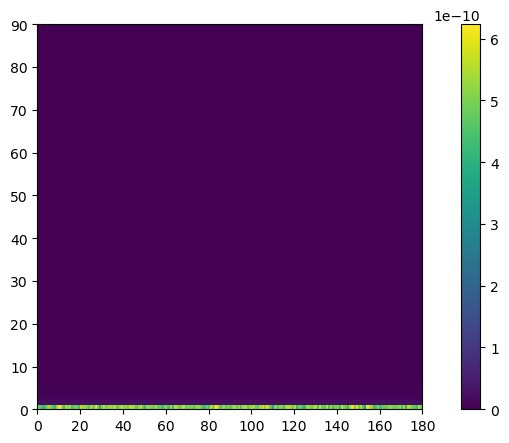

In [95]:
normpar = colors.LogNorm()
fig, _ = plt.subplots(figsize = (10,5))
smearplot = plt.imshow(event4, # plot the smearing values as an image, because python
                       # cmap = "CMRmap", # nice colormap
                       cmap = 'viridis',
                       interpolation = 'nearest', # avoid smoothing
                       origin = 'lower', # (0,0) is in the bottom left corner
                       extent = (0, 180, 0, 90), # set axis ranges
                       #norm = normpar, # log scale
                       aspect=2)
#plt.title('Smearing matrix', fontsize = 20)
#plt.xlabel('Neutrino energy (GeV)', fontsize = 20)
#plt.xticks( fontsize = 20 )
#plt.ylabel('Smeared reconstructed energy (GeV)', fontsize = 20)
#plt.yticks( fontsize = 20 )
plt.colorbar(smearplot)
#cbar = plt.colorbar(smearplot)
#cbar.ax.tick_params( labelsize = 20, length = 10, width = 2 )

plt.show()

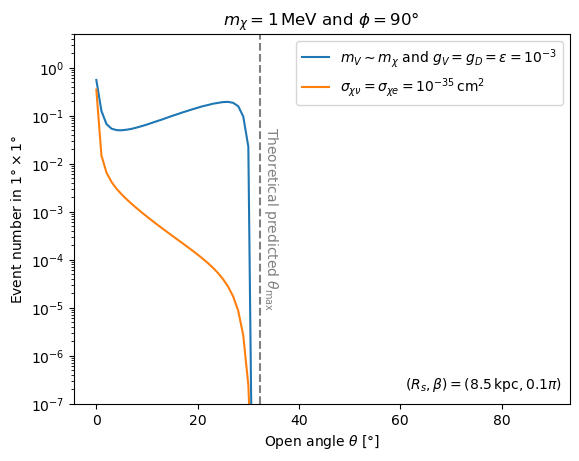

In [69]:
plt.plot(np.arange(90),event2.T[90]*totalEffect,label=r'$m_V\sim m_\chi$ and $g_V=g_D=\epsilon=10^{-3}$')
plt.plot(np.arange(90),event5.T[90]*totalEffectLegacy,label=r'$\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-35}\,{\rm cm^2}$')
plt.plot([thetaM*180/np.pi]*2,[1e-7,5],'--',color='grey')
plt.text(1.01*thetaM*180/np.pi,7e-4, r'Theoretical predicted $\theta_{\rm max}$',color='grey',verticalalignment='center',rotation=270)
plt.text(92,2e-7, r'$(R_s,\beta)=(8.5\,{\rm kpc},0.1\pi)$',horizontalalignment='right')
plt.legend()
plt.xlabel(r'Open angle $\theta~[\degree]$')
plt.ylabel(r'Event number in $1\degree\times 1\degree$')
plt.yscale('log')
plt.ylim(1e-7,5)
plt.title(r'$m_\chi=1\,{\rm MeV}$ and $\phi=90\degree$')
plt.savefig('../plots/eventTheta_phi90deg_beta0.1pi.pdf',bbox_inches='tight')

In [58]:
10**-3.1505

0.000707131200681301

(0.07, 0.073)

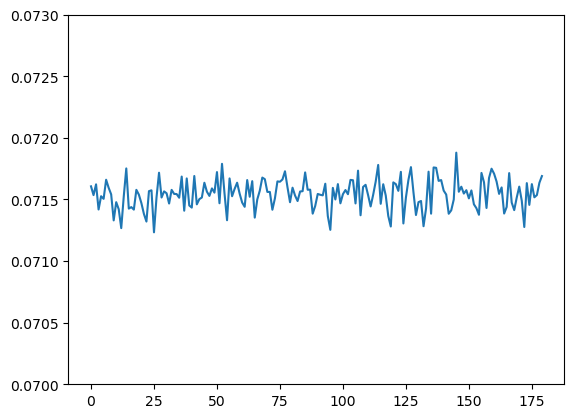

In [9]:
gV=1e-3
gD=1e-3
eps = gV
sigxv_fac = 1.05e10
sigxe = 1.05e-34
plt.plot(np.arange(180),event1[2]*7.473e33*gV**2*gD**4*eps**2)
plt.plot(np.arange(180),event3[2]*7.473e33*sigxv_fac*sigxe)
#plt.yscale('log')
plt.ylim(0.07,0.073)

Text(0, 0.5, 'event')

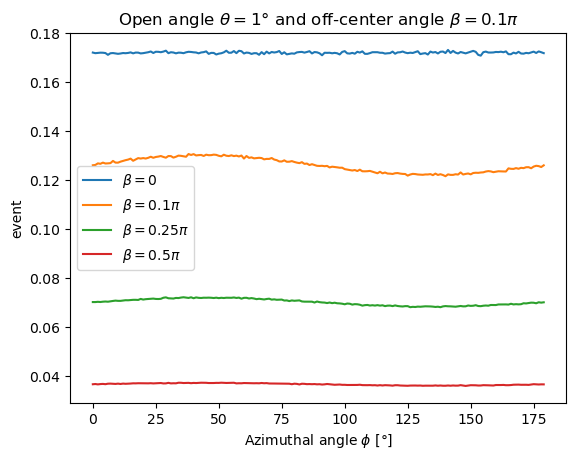

In [52]:
plt.plot(np.arange(180),event1[1]*7.473e33*gV**2*gD**4*eps**2,label=r'$\beta=0$')
plt.plot(np.arange(180),event2[1]*7.473e33*gV**2*gD**4*eps**2,label=r'$\beta=0.1\pi$')
plt.plot(np.arange(180),event3[1]*7.473e33*gV**2*gD**4*eps**2,label=r'$\beta=0.25\pi$')
plt.plot(np.arange(180),event4[1]*7.473e33*gV**2*gD**4*eps**2,label=r'$\beta=0.5\pi$')
plt.legend()
#plt.yscale('log')
#plt.ylim(0.01,0.075)
plt.xlabel(r'Azimuthal angle $\phi~[\degree]$')
plt.title(r'Open angle $\theta = 1\degree$ and off-center angle $\beta=0.1\pi$')
plt.ylabel('event')
#plt.savefig('../plots/event_betas.pdf',bbox_inches='tight')

In [94]:
500*22*35

385000

In [89]:
#theta_ls = np.logspace(-5,np.log10(np.pi/2),50)
#phi_ls = np.linspace(0,2*np.pi,20)
gV = 1e-6
gD = 1e-6
event_Rstar1 = []
event_Rstar2 = []
mx_ls = np.logspace(-6,1.5,20)
Rstar1= 8.5
Rstar2= 17
i = 1
for mx in mx_ls:
    mV = mx/3
    # Target function
    def f1(x):
        t = x[0]
        Tx = x[1]
        theta = x[2]
        phi = x[3]
        return diffFluxAtEarth(t,Tx,mx,mV,Rstar1,theta=theta,phi=phi,beta=0,gV=gV,gD=gD)
    
    def f2(x):
        t = x[0]
        Tx = x[1]
        theta = x[2]
        phi = x[3]
        return diffFluxAtEarth(t,Tx,mx,mV,Rstar2,theta=theta,phi=phi,beta=0.5*np.pi,gV=gV,gD=gD)
    # Setup integrand for vegas
    tvan1,thetaM1 = get_tvan_thetaM(5,mx,Rstar1)
    tvan2,thetaM2 = get_tvan_thetaM(5,mx,Rstar2)
    if tvan1 > 35*yr2s: tvan1 = 35*yr2s
    else: pass
    if tvan2 > 35*yr2s: tvan2 = 35*yr2s
    else: pass
    integ1 = vegas.Integrator([[1,tvan1],[5,100],[0, thetaM1],[0,2*np.pi]])
    integ2 = vegas.Integrator([[1,tvan2],[5,100],[0, thetaM2],[0,2*np.pi]])
    result1 = integ1(f1,nitn=10,neval=10000)
    event_Rstar1.append(result1.mean)
    result2 = integ2(f2,nitn=10,neval=10000)
    event_Rstar2.append(result2.mean)
    
    print(i,end='\r')
    i+=1

Text(0, 0.5, '$\\int \\frac{d\\Phi_\\chi}{dT_\\chi dt} dT_\\chi dt$')

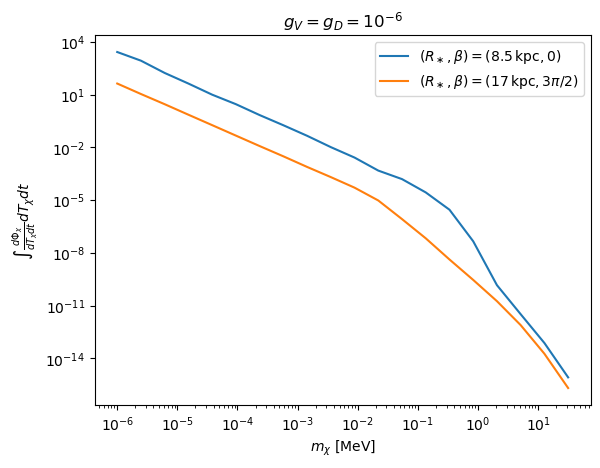

In [90]:
plt.plot(mx_ls,np.array(event_Rstar1),label=r'$(R_\ast,\beta)=(8.5\,{\rm kpc},0)$')
#plt.plot(mx_ls,event_theta001,label=r'$\beta=0.001$')
plt.plot(mx_ls,event_Rstar2,label=r'$(R_\ast,\beta)=(17\,{\rm kpc},3\pi/2)$')
#plt.plot(mx_ls,event_t_bound,'.',label=r'$t_{\rm interval}=[5\,{\rm s},35\,{\rm yrs}]$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$g_V=g_D=10^{-6}$')
plt.legend()
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$\int \frac{d\Phi_\chi}{dT_\chi dt} dT_\chi dt$')
#plt.savefig('event.pdf',bbox_inches='tight')
#plt.ylim(1e-4,1e1)

In [3]:
#Tx = 15
mx = 1e-3
Rstar = 8.5
beta = 0.1
mV = mx
tvan,_ = get_tvan_thetaM(Tx,mx,Rstar)

In [5]:
integ = vegas.Integrator([[10,tvan],[5,100],[0,np.pi/2],[0,2*np.pi]])


In [6]:
def _f(x):
    t = x[0]
    Tx = x[1]
    theta = x[2]
    phi = x[3]
    return diffEventRateAtDetector(t,Tx,mx,mV,Rstar,theta,phi,beta)

In [8]:
integ(_f,nitn=10,neval=2000).mean

233.60818883868015

In [22]:
95/5

19.0

In [25]:
from functools import partial

In [48]:
def test(a,b,c,d):
    return a,b,c,d

In [49]:
test(1,2,3,4)

(1, 2, 3, 4)

In [55]:
testP=partial(test,c=3,b=2)

In [56]:
testP(1,d=4)


(1, 2, 3, 4)

In [66]:
np.load('1.0.npy',allow_pickle=True).ndim

1

In [69]:
np.array([[1],[3]]).ndim

2

In [61]:
np.concatenate(([1.,2],[19,59,33,1]))

array([ 1.,  2., 19., 59., 33.,  1.])

In [73]:
np.vstack(([7,8,9,10],np.array([[1,0],[2,0],[3,0],[4,0]]).T))

array([[ 7,  8,  9, 10],
       [ 1,  2,  3,  4],
       [ 0,  0,  0,  0]])

In [90]:
f'{7{6}0:d}'

SyntaxError: f-string: invalid syntax (2144201710.py, line 1)

In [13]:
(3*kpc2cm/0.995/lightSpeed - 3*kpc2cm/lightSpeed)/yr2s

49.20298077829207

In [10]:
getVelocity(10,1)

0.9958591954639384

In [15]:
3*kpc2cm/lightSpeed/yr2s

9791.39317488005

In [4]:
(3*kpc2cm/getVelocity(10,0.1)/lightSpeed - 3*kpc2cm/lightSpeed)/yr2s

0.47995849027009496

In [5]:
getVelocity(10,0.1)

0.9999509839962453